# 안개 발생 진단 분류 모델 데이터셋 EDA

## 1. 데이터 설명

- 컬럼

    - `Year` : 년도
    - `Month` : 월
    - `Day` : 일
    - `Time` : 시간 (0 ~ 23)
    - `Minute` : 분 (10분 단위)
    - `STN_ID` : 지점 번호
    - `WS10(deg)` : 10분 평균 풍향, 단위: deg
    - `WS10(m/s)` : 10분 평균 풍속, 단위: m/s
    - `TA` : 1분 평균 기온 10분 주기, 단위: C
    - `RE` : 강수 유무 (0:무강수, 1:강수)
    - `HM` : 1분 평균 상대 습도 10분 주기, 단위: %
    - `sun10` : 1분 일사량 10분단위 합계, 단위: MJ
    - `TS` : 1분 평균 지면온도 10분 주기, 단위: C
    - `VIS1` : 1분 평균 시정 10분 주기, 단위: C (VIS1 변수는 시정 구간을 알 수 있는 변수로 검증 데이터에서는 제외)
    - `class` : 시정 구간

- 시정 계급 기준 (비고: 안개의 기준)

    - `1` : 0 < 시정 < 200
    - `2` : 200 <= 시정 < 500
    - `3` : 500 <= 시정 < 1000
    - `4` : 1000 <= 시정


## 2. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import rcParams

import os
import pickle
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

# pd.set_option("float_format", "{:.4f}".format)
pd.set_option("display.max_columns", None)

In [2]:
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

### 2-1 로컬 디렉토리 경로

In [3]:
# 작업 디렉토리 변경 (로컬 디렉토리에서 작업시 실행)

def get_local_path(train_dataset_name, test_dataset_name):

    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 상위 디렉토리에 fog_data가 없다면 fog_data 폴더 생성
    # (이미 폴더 있어도 exist_ok=True면 넘어감)
    os.makedirs("fog_data", exist_ok=True)

    # train/test 데이터셋 경로 잡아준다
    train_path = os.path.join(os.getcwd(), "fog_data", train_dataset_name)
    test_path = os.path.join(os.getcwd(), "fog_data", test_dataset_name)

    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        train_path = train_path.replace("\\", "/")
        test_path = test_path.replace("\\", "/")

    # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return train_path, test_path

In [4]:
train_path, test_path = get_local_path("fog_train.csv", "fog_test.csv")

### 2-2. colab 디렉토리 경로 (colab 작업시)

In [5]:
# # 구글 드라이브 파일 접근
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# # colab 파일 경로 생성 함수
# # colab에서 작업시 주석 풀고 실행

# def get_colab_path(train_dataset_name, test_dataset_name):

#     fog_folder = "drive/MyDrive/weather_bigdata/fog_data"
#     os.makedirs(fog_folder, exist_ok=True)

#     # train/test 데이터셋 경로 잡아준다
#     train_path = os.path.join(os.getcwd(), fog_folder, train_dataset_name)
#     test_path = os.path.join(os.getcwd(), fog_folder, test_dataset_name)

#     return train_path, test_path

In [7]:
# train_path, test_path = get_colab_path("fog_train.csv", "fog_test.csv")

In [8]:
train_df = pd.read_csv(train_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)
test_df = pd.read_csv(test_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)

In [9]:
train_df.head(3)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
0,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
1,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
2,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4


In [10]:
test_df.head(3)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,L,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
1,L,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
2,L,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN


In [11]:
train_df[train_df.duplicated()]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class


In [12]:
test_df[test_df.duplicated()]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class


## 3. Preprocessing

In [13]:
# train, test 데이터셋에서 -99, -99.9 포함한 컬럼 동일하기 때문에 같이 변수로 선언
cols_99 = train_df.columns[train_df.isin([-99]).any()].tolist()
cols_99_9 = train_df.columns[train_df.isin([-99.9]).any()].tolist()

In [14]:
print("Train 데이터셋 -99인 값 포함 컬럼 :", cols_99)
print("Train 데이터셋 -99.9인 값 포함 컬럼 :", cols_99_9)

Train 데이터셋 -99인 값 포함 컬럼 : ['vis1', 'class']
Train 데이터셋 -99.9인 값 포함 컬럼 : ['ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts']


### 3-1. 데이터셋 분리 (Train / Validation)

In [15]:
train_df, val_df = train_test_split(train_df, random_state=42, train_size=0.75, stratify=train_df["class"])

In [16]:
train_df.shape, val_df.shape


((2367344, 15), (789115, 15))

### 3-2. 컬럼 수정 및 제거 함수

In [17]:
# 컬럼 수정 및 제거 함수
def modify_columns(train_df, val_df, test_df):

    # stn_id 수정 : A, B, C, D, E로 수정
    train_df["stn_id"] = train_df["stn_id"].apply(lambda x: x[0])
    val_df["stn_id"] = val_df["stn_id"].apply(lambda x: x[0])
    test_df["stn_id"] = test_df["stn_id"].apply(lambda x: x[0])

    # year, month, day, time, minute, 컬럼 drop
    # train_df.drop(columns=["year", "month", "day", "time", "minute", "vis1"], inplace=True)
    # test_df.drop(columns=["year", "month", "day", "time", "minute"], inplace=True)

    # hm = 0인 데이터 index 찾아서 drop
    hm_zero_idx = train_df[train_df['hm'] == 0].index
    train_df.drop(hm_zero_idx, inplace=True)

    # day, minute 컬럼 제거
    train_df.drop(columns=["day", "minute"], inplace=True)
    val_df.drop(columns=["day", "minute"], inplace=True)
    test_df.drop(columns=["day", "minute"], inplace=True)

    return train_df, val_df, test_df

In [18]:
train_df, val_df, test_df = modify_columns(train_df, val_df, test_df)

### 3-3. 안개 여부 컬럼 생성 함수
- `class` = 4 : 안개 X (0)
- `class` <= 3 : 안개 O (1)

In [19]:
def is_fog(df, column):
    df["is_fog"] = df[column].apply(lambda x: 0 if x > 3 else 1)
    return df

In [20]:
train_df = is_fog(train_df, "class")
val_df = is_fog(val_df, "class")
test_df = is_fog(test_df, "class")


In [21]:
# class 컬럼 값 count
class_cnt = train_df["class"].value_counts().to_frame()

# class 컬럼 값 비율
class_pct = train_df["class"].value_counts(normalize=True).to_frame()

# 개수, 비율 concat
pd.concat([class_cnt, class_pct], axis=1).sort_index()

,count,proportion
class,,
-99,16887,0.007133
1,5899,0.002492
2,9066,0.003830
3,9135,0.003859
4,2326356,0.982686


### 3-4. 이슬점

#### 3-4-1. 이슬점 생성 함수

In [22]:
def calculate_dew_point(T, RH):
    # 이슬점 생성 함수
    # T : 기온, RH : 상대 습도

    # b = 17.27
    # c = 237.7
    b = 17.62
    c = 234.12

    gamma = (b * T) / (c + T) + np.log(RH / 100.0)
    dew_point = (c * gamma) / (b - gamma)

    return dew_point

In [23]:
train_df["dew_point"] = calculate_dew_point(train_df['ta'], train_df['hm'])
val_df["dew_point"] = calculate_dew_point(val_df['ta'], val_df['hm'])
test_df["dew_point"] = calculate_dew_point(test_df['ta'], test_df['hm'])

In [24]:
# dew_point가 NaN인 데이터의 hm 확인 → 전부 -99.9 
print("train_df dew_point가 NaN인 데이터의 hm 컬럼 value_counts:", train_df[train_df["dew_point"].isnull()]["hm"].value_counts(), "\n")
print("val_df dew_point가 NaN인 데이터의 hm 컬럼 value_counts:", val_df[val_df["dew_point"].isnull()]["hm"].value_counts(), "\n")
print("test_df dew_point가 NaN인 데이터의 hm 컬럼 value_counts:", test_df[test_df["dew_point"].isnull()]["hm"].value_counts(), "\n")

train_df dew_point가 NaN인 데이터의 hm 컬럼 value_counts: hm
-99.9    2701
Name: count, dtype: int64 

val_df dew_point가 NaN인 데이터의 hm 컬럼 value_counts: hm
-99.9    915
Name: count, dtype: int64 

test_df dew_point가 NaN인 데이터의 hm 컬럼 value_counts: hm
-99.9    57
Name: count, dtype: int64 



#### 3-4-2. 이슬점 도달 여부 함수

In [25]:
def diff_ts_dew(df, ts, dew_point):
    # 기온 - 이슬점 <= 0, 이슬점 온도보다 기온이 낮다는 뜻
    df["dew_reached"] = df.apply(lambda x: 1 if (x[ts] - x[dew_point] <= 0) else 0, axis=1)

    return df       

In [26]:
train_df = diff_ts_dew(train_df, "ts", "dew_point")
val_df = diff_ts_dew(val_df, "ts", "dew_point")
test_df = diff_ts_dew(test_df, "ts", "dew_point")

### 3-5. 온도 차이 함수 (기온 - 지표면 온도)

In [27]:
def temp_diff(df):
    df["temp_diff"] = df["ta"] - df["ts"]
    return df

In [28]:
train_df = temp_diff(train_df)
val_df = temp_diff(val_df)
test_df = temp_diff(test_df)

### 3-6. 풍향 수정
- `ws10_deg` 가 360인 것 → 0으로 변경 (일단 미적용)
- `ws10_deg`에 맞게 8방위로 변경

In [29]:
# def switch_wind_degree(df, col):
#     # 풍향 360인 것 0으로 변경
#     df[col] = df[col].apply(lambda x: 0 if x==360 else x)
#     return df

In [30]:
def cardinal_points(df, column):

    # 8방위 : 45도 경계선, 16방위 : 22.5도 경계선
    
    # # ws10_deg 컬럼을 16방위로 환산
    # cardinal_points = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", 
    #                "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]

    # val = int((num/45)+.5)
    val = df[column].apply(lambda x: int(x/45+.5))

    # ws10_deg 컬럼을 8방위로 환산
    direction_points = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
    

    # 환산한 방위를 반영한 새로운 컬럼 생성
    df["ws10_dir"] = val.apply(lambda x: direction_points[(x % 8)])

    return df

In [31]:
train_df = cardinal_points(train_df, "ws10_deg")
val_df = cardinal_points(val_df, "ws10_deg")
test_df = cardinal_points(test_df, "ws10_deg")

### 3-7. 카테고리컬 변수 생성

In [32]:
def make_categorical(df, col_list):

    # class 컬럼 순서형 변수로 변경
    for column in col_list:
        if column in ["month", "class"]:
            df[column] = pd.Categorical(df[column],
                                        # categories=[1, 2, 3, 4, -99],
                                        categories=np.unique(df[column]),
                                        ordered=True)
        else:
            df[column] = pd.Categorical(df[column],
                                        # categories=[1, 2, 3, 4, -99],
                                        categories=np.unique(df[column]),
                                        ordered=False)

    return df

In [33]:
# 범주형 변수들을 categorical_list에 선언

# month도 순서가 있기 때문에 ordinal
# https://wikidocs.net/161040#ordinal

categorical_list = ["month", "re", "is_fog", "dew_reached", "class"]
train_df = make_categorical(train_df, categorical_list)
val_df = make_categorical(val_df, categorical_list)

In [34]:
# test 데이터셋에는 class 컬럼이 없기 때문에, class 컬럼을 삭제한다
categorical_list.pop()
test_df = make_categorical(test_df, categorical_list)

### 3-8. 전처리 마친 데이터셋 피클 저장

In [35]:
def pickle_local_path(dataset_name):

    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 상위 디렉토리에 fog_data가 없다면 fog_data 폴더 생성
    # (이미 폴더 있어도 exist_ok=True면 넘어감)
    os.makedirs("fog_data", exist_ok=True)

    # train/test 데이터셋 경로 잡아준다
    path = os.path.join(os.getcwd(), "fog_data", dataset_name)

    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        path = path.replace("\\", "/")

    # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return path

In [101]:
train_pkl_path = pickle_local_path("train_checkpoint.pickle")
val_pkl_path = pickle_local_path("val_checkpoint.pickle")
test_pkl_path = pickle_local_path("test_checkpoint.pickle")

In [37]:
# 데이터프레임 train, val, test 저장
with open(train_pkl_path, 'wb') as f:
    pickle.dump(train_df, f)

with open(val_pkl_path, 'wb') as f:
    pickle.dump(val_df, f)

with open(test_pkl_path, 'wb') as f:
    pickle.dump(test_df, f)

### 3-6. 결측치 치환 함수

In [38]:
# 결측치 처리하지 않은 train 데이터셋 copy
# train_df_with_nan = train_df.copy()

In [39]:
# # -99, -99.9인 데이터를 np.nan으로 치환하는 함수

# def switch_to_nan(df):
#     df = df.replace({-99:np.nan, -99.9:np.nan})    
#     # train_df = train_df.replace({-99:np.nan, -99.9:np.nan})
#     # test_df = test_df.replace({-99:np.nan, -99.9:np.nan})
#     df.dropna(inplace=True)
    
#     return df

## 4. EDA

In [40]:
# 명목형 변수 값 확인
cat_col_names = train_df.select_dtypes(exclude=np.number).columns

for col_name in cat_col_names:
    cat_values = np.unique(train_df[col_name])
    print(f"{col_name}: {cat_values}\n")

year: ['I' 'J' 'K']

month: [ 1  2  3  4  5  6  7  8  9 10 11 12]

stn_id: ['A' 'B' 'C' 'D' 'E']

re: [-99.9   0.    1. ]

class: [-99   1   2   3   4]

is_fog: [0 1]

dew_reached: [0 1]

ws10_dir: ['E' 'N' 'NE' 'NW' 'S' 'SE' 'SW' 'W']



In [41]:
# 수치형 변수 최대, 최소값 확인
num_col_names = train_df.select_dtypes(include=np.number).columns

for col_name in num_col_names:
    print(f"{col_name}: ({train_df[col_name].min()}, {train_df[col_name].max()})")

time: (0, 23)
ws10_deg: (-99.9, 360.0)
ws10_ms: (-99.9, 22.5)
ta: (-99.9, 37.8)
hm: (-99.9, 100.0)
sun10: (-99.9, 20.83)
ts: (-99.9, 70.1)
vis1: (-99, 60525)
dew_point: (-106.84325967115815, 29.83689797028356)
temp_diff: (-146.5, 133.60000000000002)


In [42]:
train_df.describe()

,time,ws10_deg,ws10_ms,ta,hm,sun10,ts,vis1,dew_point,temp_diff
count,2.367343e+06,2.367343e+06,2.367343e+06,2.367343e+06,2.367343e+06,2.367343e+06,2.367343e+06,2.367343e+06,2.364642e+06,2.367343e+06
mean,1.149973e+01,1.852342e+02,1.999755e+00,1.328635e+01,6.667784e+01,-1.280910e+00,1.282451e+01,1.963235e+04,6.856313e+00,4.618393e-01
std,6.922348e+00,1.072130e+02,4.714799e+00,1.100714e+01,2.173477e+01,1.168046e+01,2.258689e+01,1.206221e+04,1.174853e+01,1.617349e+01
min,0.000000e+00,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.990000e+01,-9.900000e+01,-1.068433e+02,-1.465000e+02
25%,5.000000e+00,8.470000e+01,9.000000e-01,5.500000e+00,5.130000e+01,0.000000e+00,5.100000e+00,1.229000e+04,-1.995170e+00,-3.300000e+00
50%,1.100000e+01,2.094000e+02,1.800000e+00,1.430000e+01,6.870000e+01,0.000000e+00,1.570000e+01,2.000000e+04,6.998212e+00,-6.000000e-01
75%,1.700000e+01,2.769000e+02,3.000000e+00,2.200000e+01,8.470000e+01,1.600000e-01,2.430000e+01,2.000000e+04,1.724046e+01,1.200000e+00
max,2.300000e+01,3.600000e+02,2.250000e+01,3.780000e+01,1.000000e+02,2.083000e+01,7.010000e+01,6.052500e+04,2.983690e+01,1.336000e+02


### 4-1. 월별 안개 발생 분포 확인

In [43]:
# 안개가 발생한 것만 필터링하여 fog_yes_df에 선언
fog_yes_df = train_df.groupby(["month"])[["is_fog", "class"]].value_counts().to_frame()

In [44]:
# 월별 안개발생 빈도를 따로 groupby하여, fog_yes_total에 선언
fog_tot_num = train_df[train_df["is_fog"]==1].groupby(["month"])["class"].count().to_frame()
fog_tot_num = fog_tot_num.rename(columns={"class":"tot_cnts"}).reset_index()

In [45]:
,# season_df에서 안개가 낀 데이터만 가져옴
is_fog_df = fog_yes_df.reset_index()[(fog_yes_df.reset_index()["is_fog"] == 1) & (fog_yes_df.reset_index()["class"] != 4)]

# season 별 stn_id의 비율을 구하기 위해 season_fot_tot_num 데이터프레임과 merge
is_fog_df = is_fog_df.merge(fog_tot_num)

is_fog_df["fog_distribution"] = is_fog_df["count"] / is_fog_df["tot_cnts"]

# season, stn_id 컬럼 순으로 정렬
is_fog_df = is_fog_df.sort_values(["month", "class"])

# # proportion을 %로 만들어주고 소수 셋째자리에서 반올림
# is_fog_df["proportion"] = is_fog_df["proportion"].apply(lambda x: np.round(x*100, 2))

is_fog_df["fog_distribution"] = is_fog_df["fog_distribution"].apply(lambda x: np.round(x*100, 2))

In [46]:
is_fog_df

,month,is_fog,class,count,tot_cnts,fog_distribution
1,1,1,-99,648,2631,24.63
3,1,1,1,389,2631,14.79
2,1,1,2,587,2631,22.31
0,1,1,3,1007,2631,38.27
5,2,1,-99,449,1898,23.66
7,2,1,1,270,1898,14.23
6,2,1,2,393,1898,20.71
4,2,1,3,786,1898,41.41
9,3,1,-99,747,2927,25.52
8,3,1,1,797,2927,27.23


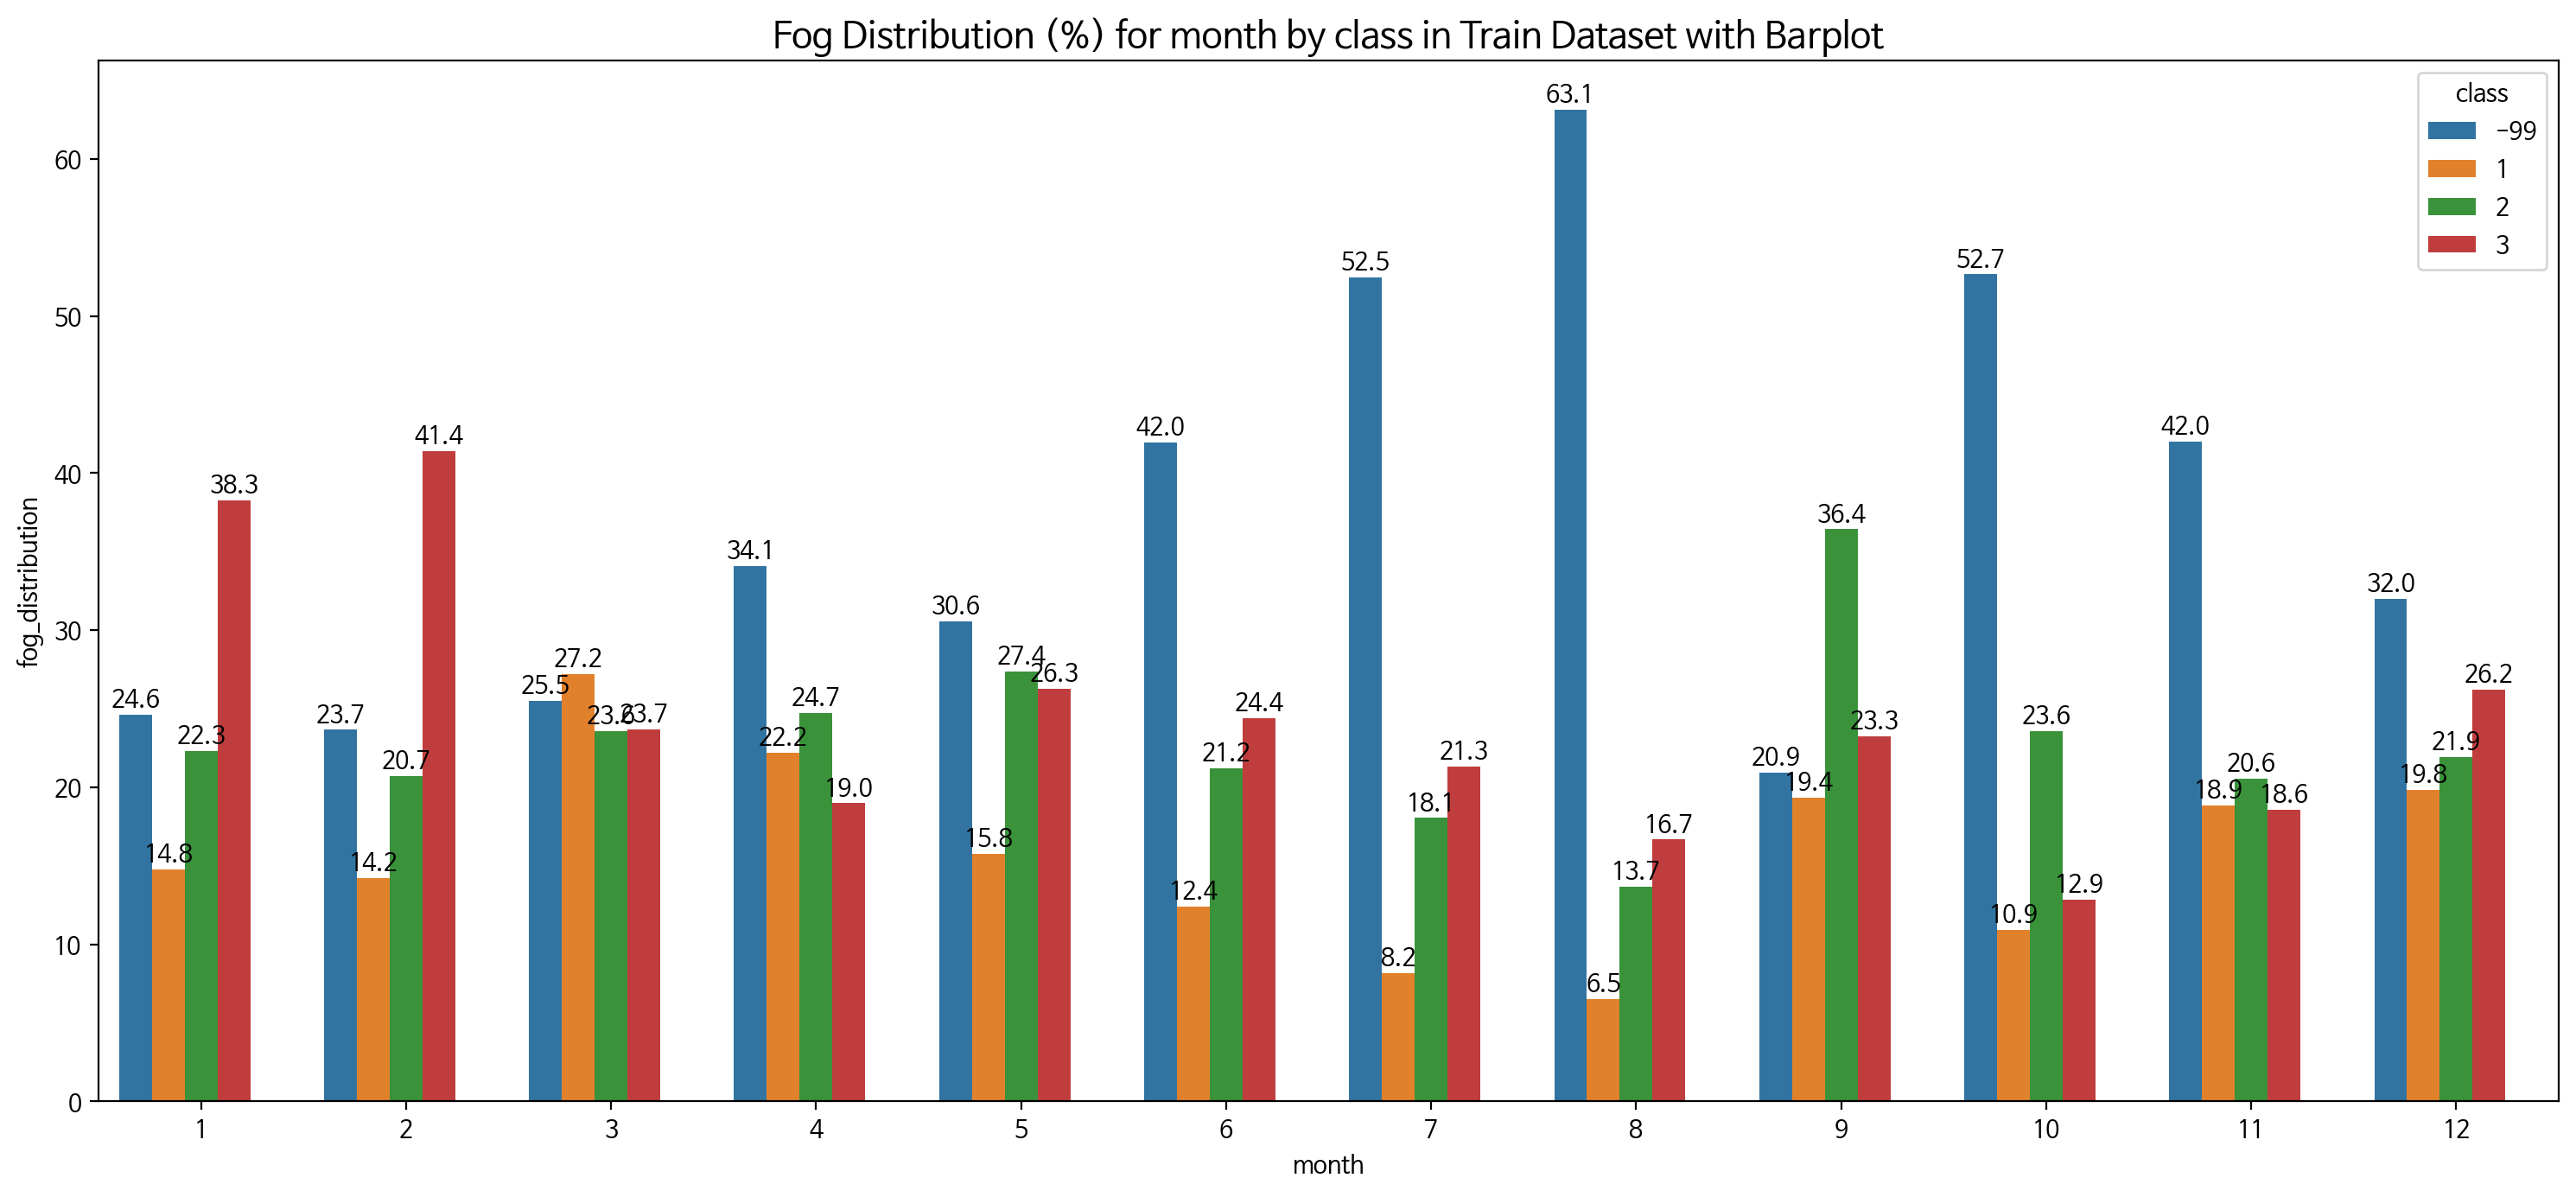

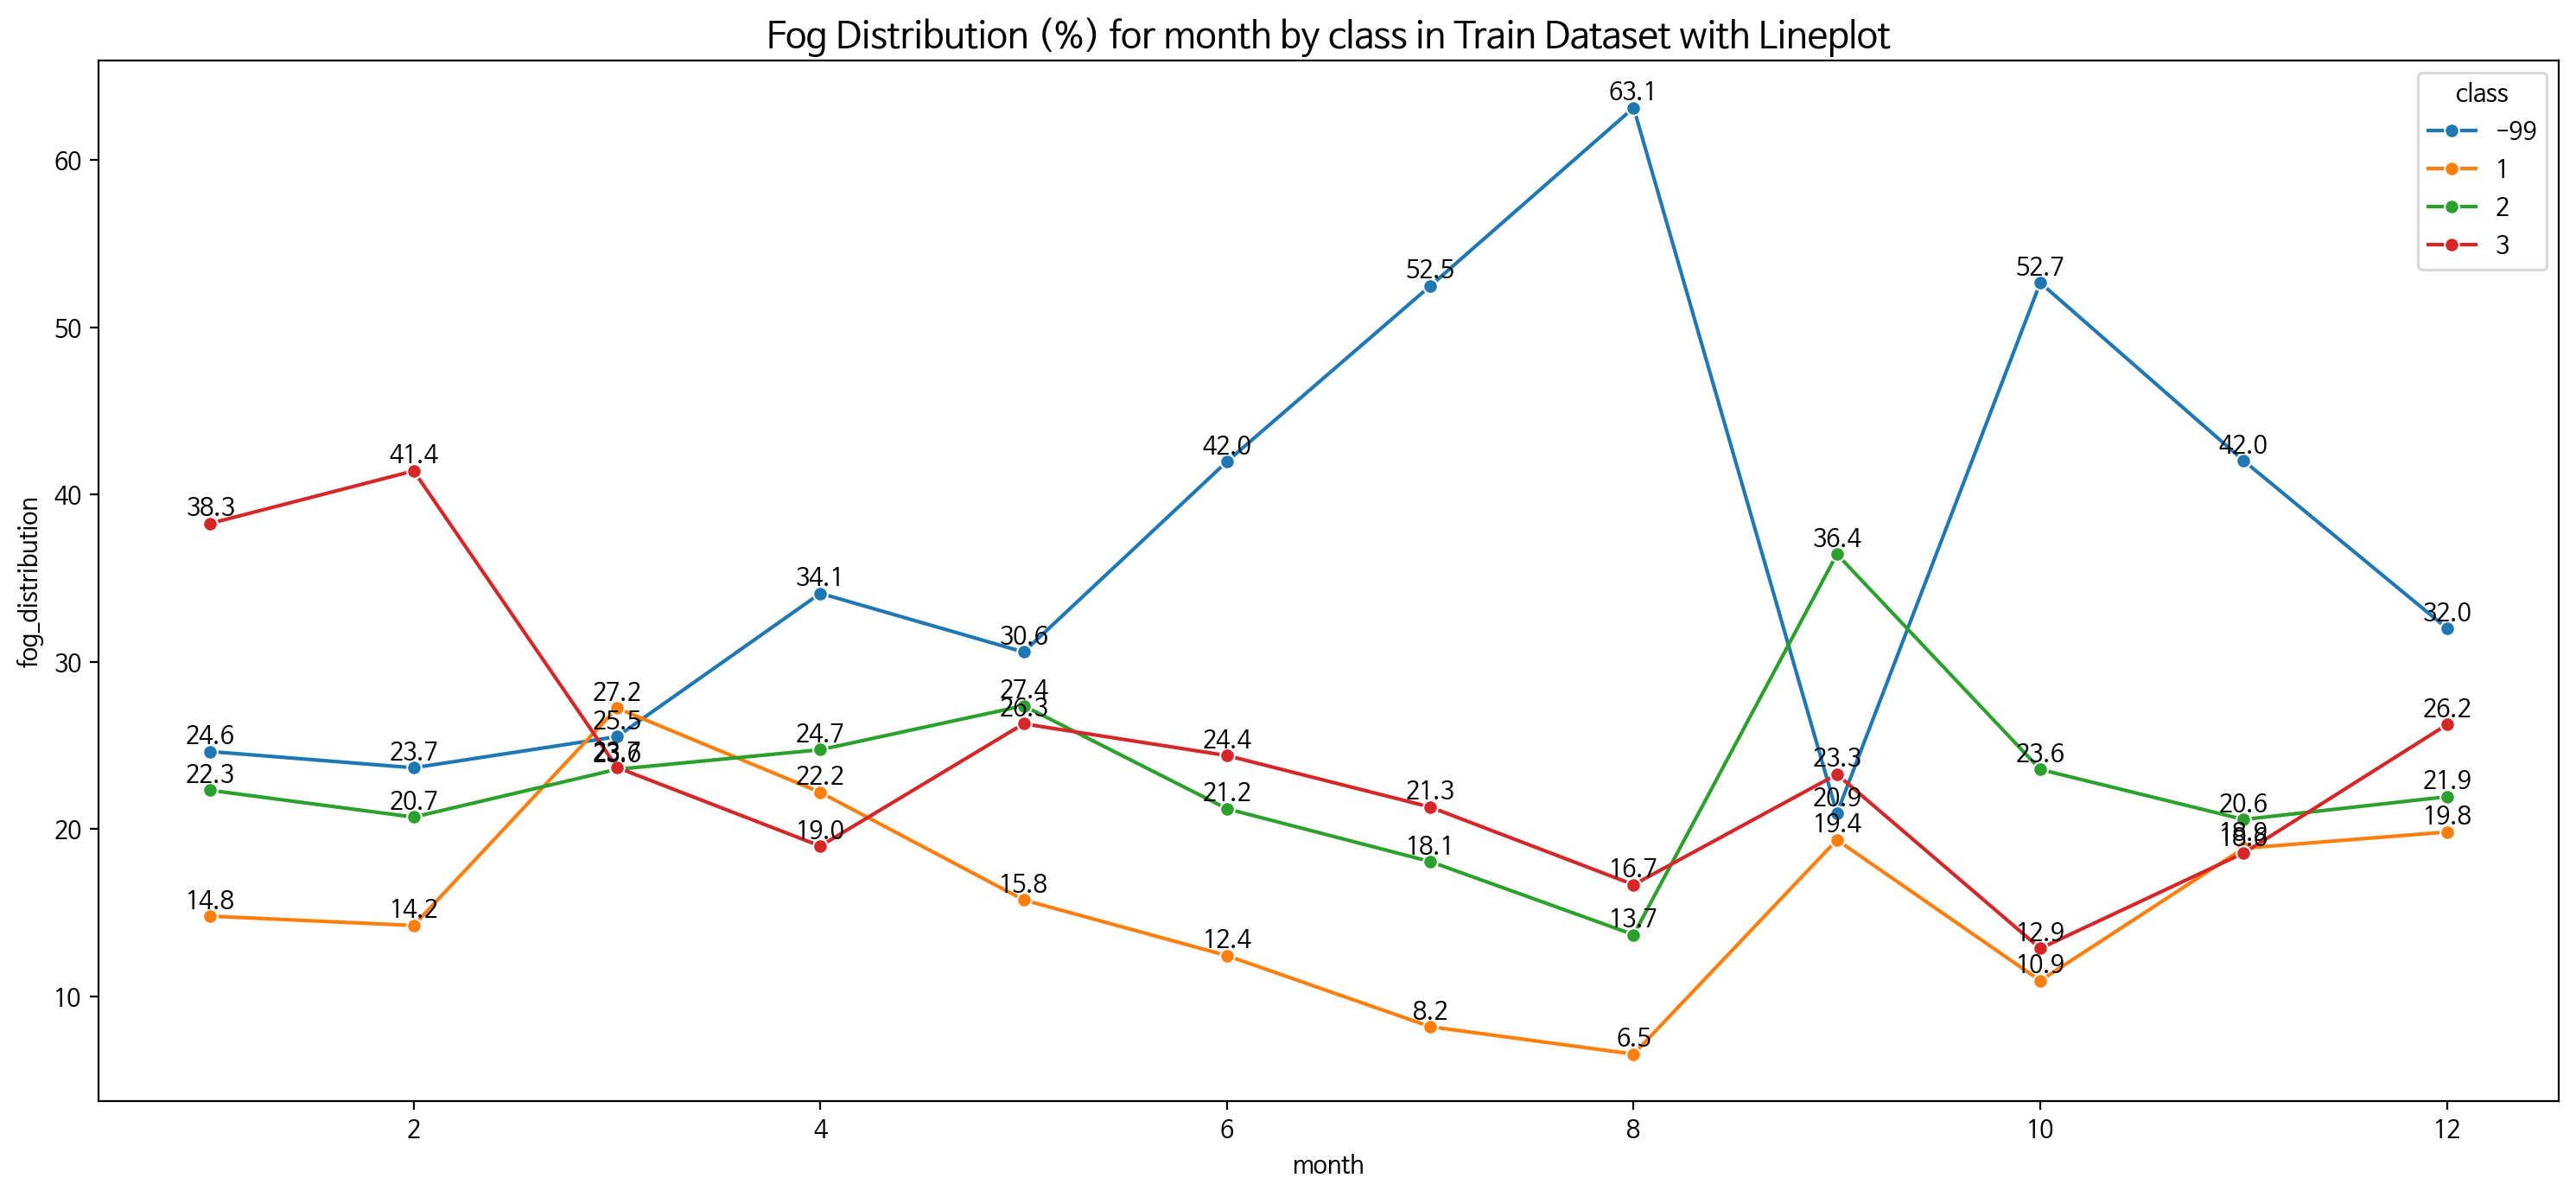

In [47]:
# class=4가 아닌 데이터만 선택
# filtered_data = fog_yes_group[fog_yes_group['class'] != 4]

plt.figure(figsize=(15, 7))

# 막대 그래프 생성
sns_pct = sns.barplot(x="month", 
                      y="fog_distribution", 
                      hue="class", 
                      data=is_fog_df)

# x축 레이블 회전
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), 
                        # rotation=30
                        )

# 막대 그래프 상단에 비율 (%) 표기
# 각 x 좌표별로 높이를 저장
heights_by_x = {}

for bar in sns_pct.patches:
    height = bar.get_height()  # 막대의 높이 가져오기
    if height > 0:  # 높이가 0보다 클 때만 텍스트 추가
        x = bar.get_x() + bar.get_width() / 2  # 텍스트 위치 x좌표

        if x not in heights_by_x:
            heights_by_x[x] = []

        # 이전 높이값이 존재하면, 새로운 텍스트 위치를 조정
        if heights_by_x[x]:
            previous_heights = sorted(heights_by_x[x], reverse=True)
            # 이전 텍스트와 현재 막대 사이의 최소 간격 설정
            offset = height + 0.5
            for prev_height in previous_heights:
                if abs(prev_height - offset) < 0.5:
                    offset = prev_height + 0.5
        else:
            offset = height + 0.5

        plt.text(x,  # 텍스트 위치 x좌표
                 offset,  # 텍스트 위치 y좌표
                 "%.1f" % height,  # 소수점 둘째 자리까지 비율 표시
                 ha="center")  # 가운데 정렬

        heights_by_x[x].append(offset)

# 불필요한 범례 항목 제거
handles, labels = sns_pct.get_legend_handles_labels()
filtered_handles = [handle for handle, label in zip(handles, labels) if label != '4']
filtered_labels = [label for label in labels if label != '4']

# 시각화 제목과 폰트 크기 지정
sns_pct.set_title("Fog Distribution (%) for month by class in Train Dataset with Barplot", fontsize=15)
sns_pct.legend(filtered_handles, filtered_labels, title='class')

plt.tight_layout()
# plt.show()


# lineplot 생성
plt.figure(figsize=(15, 7))

# 라인 플롯 생성
sns_pct = sns.lineplot(x="month", 
                      y="fog_distribution", 
                      hue="class", 
                      data=is_fog_df,
                      marker='o')  # 포인트에 마커 추가

# 라인 플롯의 각 포인트에 값 표시
for line in sns_pct.lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        if y > 0:  # 높이가 0보다 클 때만 텍스트 추가
            plt.text(x, y + 0.5, f"{y:.1f}", ha="center")

# 불필요한 범례 항목 제거
handles, labels = sns_pct.get_legend_handles_labels()
filtered_handles = [handle for handle, label in zip(handles, labels) if label != '4']
filtered_labels = [label for label in labels if label != '4']

# 시각화 제목과 폰트 크기 지정
sns_pct.set_title("Fog Distribution (%) for month by class in Train Dataset with Lineplot", fontsize=15)
sns_pct.legend(filtered_handles, filtered_labels, title='class')

plt.tight_layout()
plt.show()



#### 4-1-1. 결론
- 계절별로 안개 발생 class가 다르게 나타났다 <br>
 <br>
    - 봄 (3-5) : 비교적 고른 분포 
     
    - 여름 (6-8) : class 2, 3이 주로 발생  
     
    - 가을 (9-11)
    
        - class 2가 주로 발생
        - 여름에 비해 class 1도 증가
        - class=3은 여름에 비해 대폭 감소 
     
     - 겨울 (12-2)
        - 가을에 비해, 다시 class 3이 증가
        - class 1, 2는 다시 감소하는 추세

### 4-2. 월별, 관측소별 안개 발생 빈도 분포

In [48]:
# 월별, 관측소별 안개 유무 카운팅
month_df = train_df.groupby(["month", "stn_id"])["is_fog"].value_counts().to_frame()

In [49]:
# 월별 안개가 낀 빈도수 계산하여 month_fog_tot_num에 선언
month_fog_tot_num = train_df[train_df["is_fog"]==1].groupby(["month"])["stn_id"].count().to_frame()
month_fog_tot_num = month_fog_tot_num.rename(columns={"stn_id":"tot_cnts"}).reset_index()

In [50]:
,# month_df에서 안개가 낀 데이터만 가져옴
month_is_fog = month_df.reset_index()[month_df.reset_index()["is_fog"] == 1]

# month 별 stn_id의 비율을 구하기 위해 month_fot_tot_num 데이터프레임과 merge
month_is_fog = month_is_fog.merge(month_fog_tot_num)

month_is_fog["stn_rate"] = month_is_fog["count"] / month_is_fog["tot_cnts"]


# month, stn_id 컬럼 순으로 정렬
month_is_fog = month_is_fog.sort_values(["month", "stn_id"])

month_is_fog["stn_rate"] = month_is_fog["stn_rate"].apply(lambda x: np.round(x*100, 2))

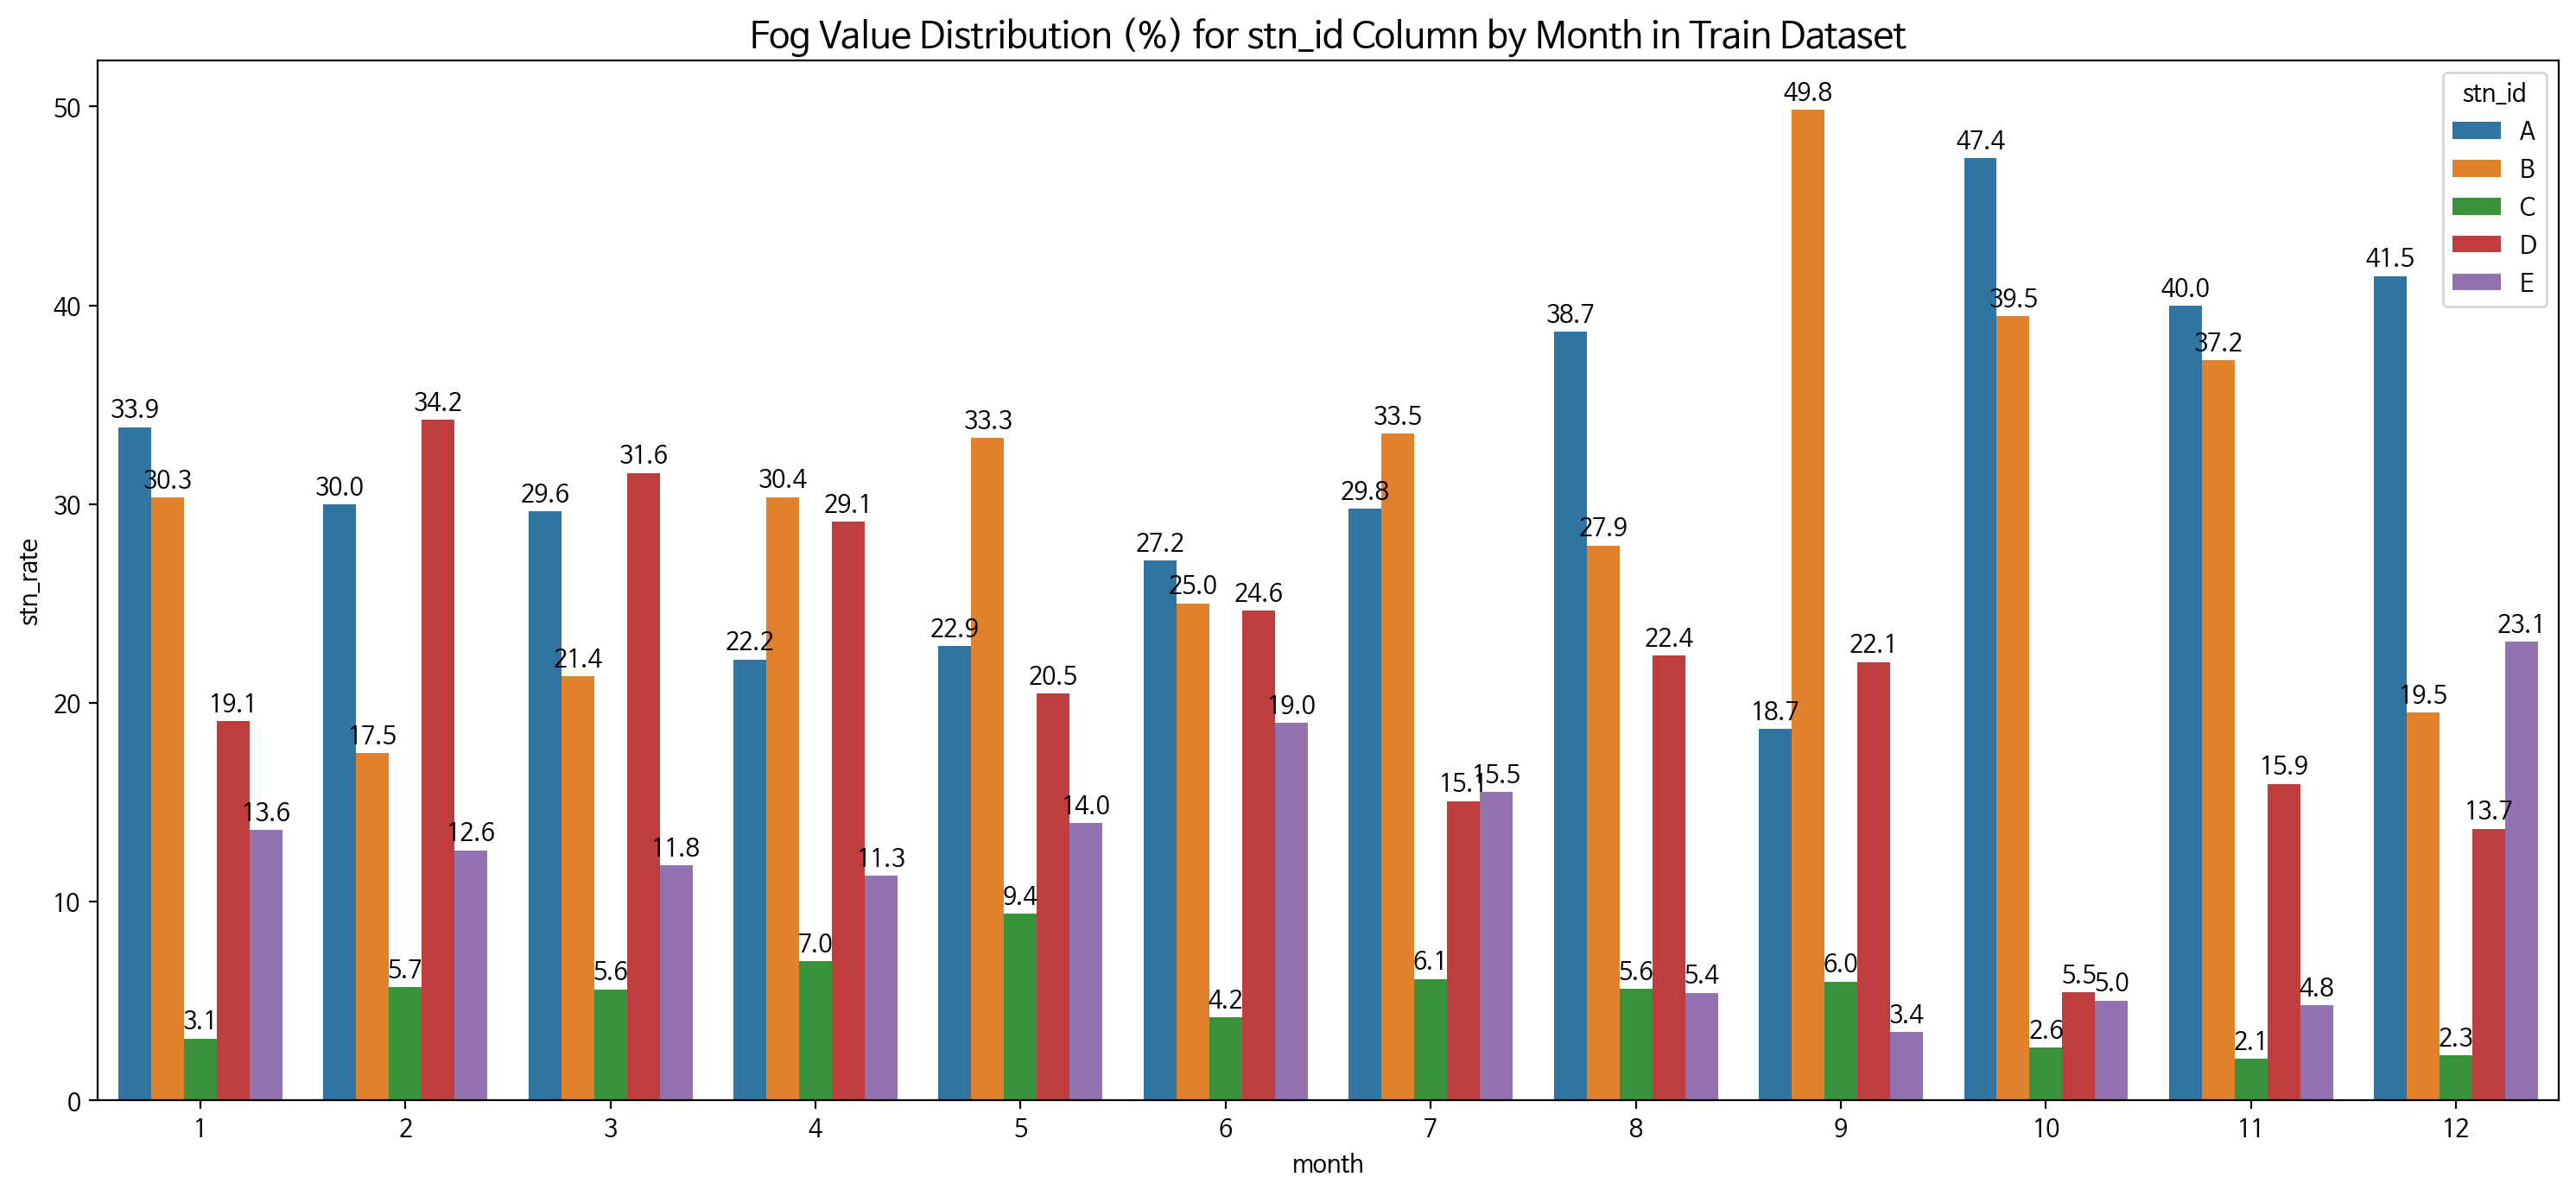

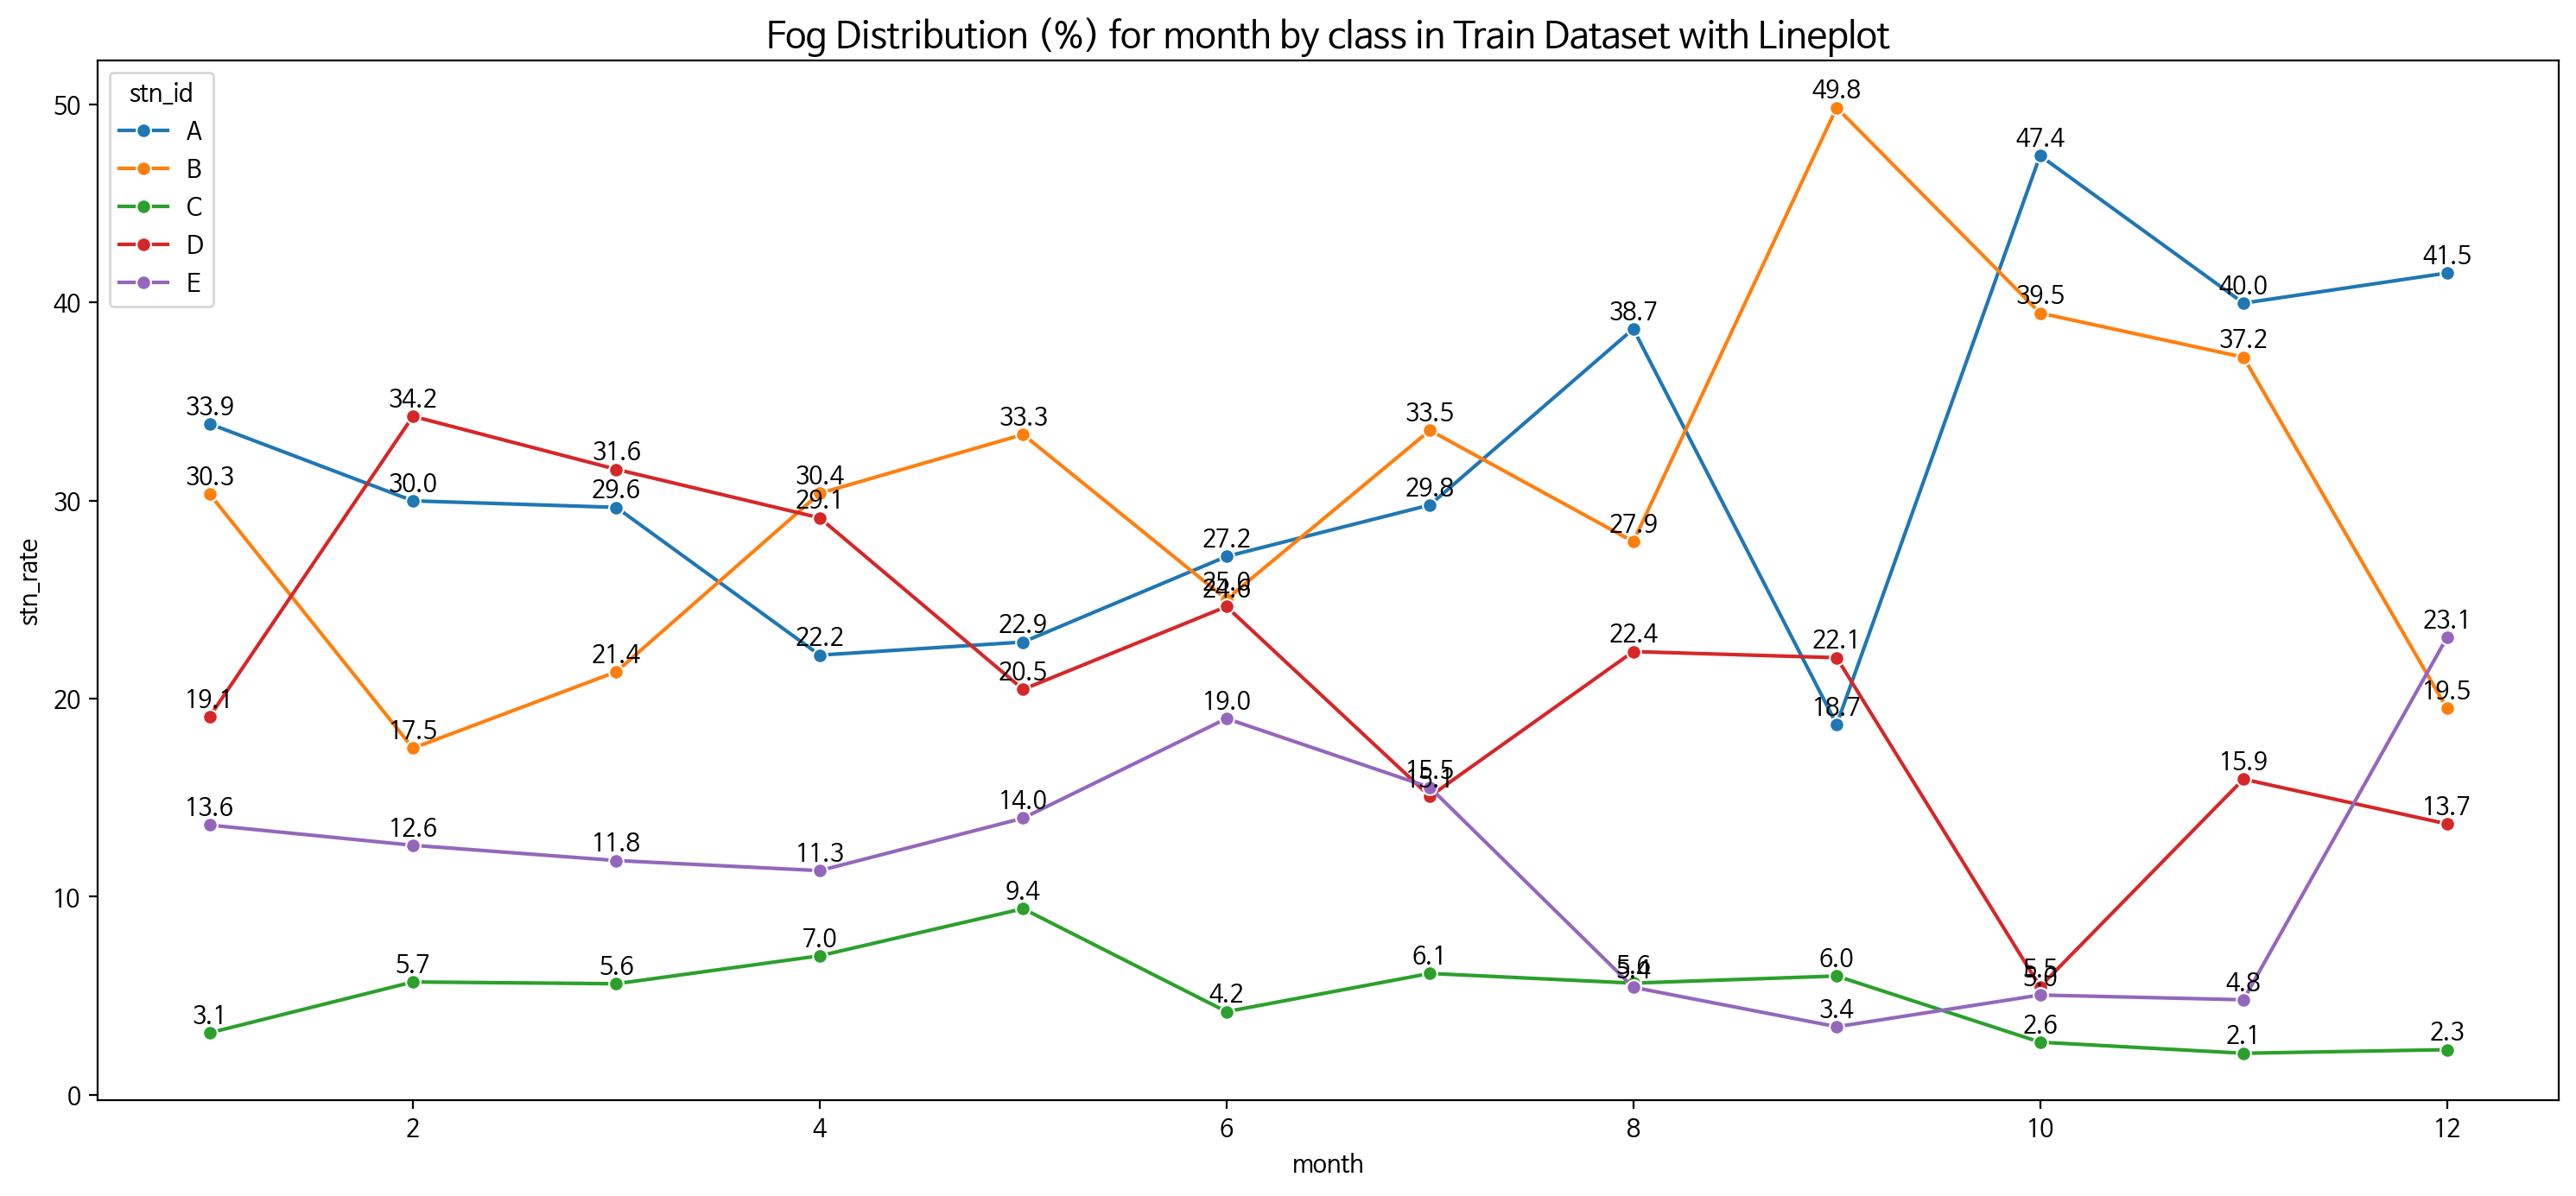

In [51]:
# 결측치 비율 시각화
plt.figure(figsize=(15, 7))

sns_pct = sns.barplot(x="month", 
                      y="stn_rate", 
                      hue="stn_id", 
                      data=month_is_fog)
                    #   data=np.round(is_fog_df * 100, 2).sort_values(["stn_id", "proportion"], ascending=[True, False]))


# sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                      # bar의 높이를 가져옴
    if height > 0:                                 # 높이가 0보다 클 때만 텍스트를 추가
        plt.text(bar.get_x() + bar.get_width()/2,  # 글자 위치 x좌표
                 height + 0.5,                   # 글자 위치 y좌표
                 "%.1f" % height,                  # 소수점 셋째 자리까지 비율 표시
                 ha="center")                      # 가운데 정렬


# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Fog Value Distribution (%) for stn_id Column by Month in Train Dataset", fontsize=15)
plt.tight_layout()
# plt.show()


# lineplot 생성
plt.figure(figsize=(15, 7))

# 라인 플롯 생성
sns_pct = sns.lineplot(x="month", 
                      y="stn_rate", 
                      hue="stn_id", 
                      data=month_is_fog,
                      marker='o')  # 포인트에 마커 추가

# 라인 플롯의 각 포인트에 값 표시
for line in sns_pct.lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        if y > 0:  # 높이가 0보다 클 때만 텍스트 추가
            plt.text(x, y + 0.5, f"{y:.1f}", ha="center")

# 불필요한 범례 항목 제거
handles, labels = sns_pct.get_legend_handles_labels()
filtered_handles = [handle for handle, label in zip(handles, labels) if label != '4']
filtered_labels = [label for label in labels if label != '4']

# 시각화 제목과 폰트 크기 지정
sns_pct.set_title("Fog Distribution (%) for month by class in Train Dataset with Lineplot", fontsize=15)
sns_pct.legend(filtered_handles, filtered_labels, title='stn_id')

plt.tight_layout()
plt.show()

#### 4-2-1. 결론
- 안개 점유율

    - A 관측소 : 3월부터 낮아졌다가 10월부터 증가
    
    - B 관측소 : 8월 이후 높아졌다가 11월부터 2월까지 감소
    - C 관측소 : 전체적으로 저조, 3월부터 5월까지 소폭 증가
    - D 관측소 : 6월부터 8월까지 감소
    - E 관측소 : 7월부터 11월까지 감소, 이후 증가 추세 <br>
<br>
- 가을, 겨울에 내륙에서 안개가 더 많이 발생한다는 점에서, **A**, **B**는 내륙에 위치할 가능성이 크다

    - A, B는 10 ~ 12월 정반대 추세를 보인다
    
    - 11월에 서로 역전된다


### 4-3 이상치 확인 

#### 4-3-1. 이상치 시각화 (temp_diff 컬럼)

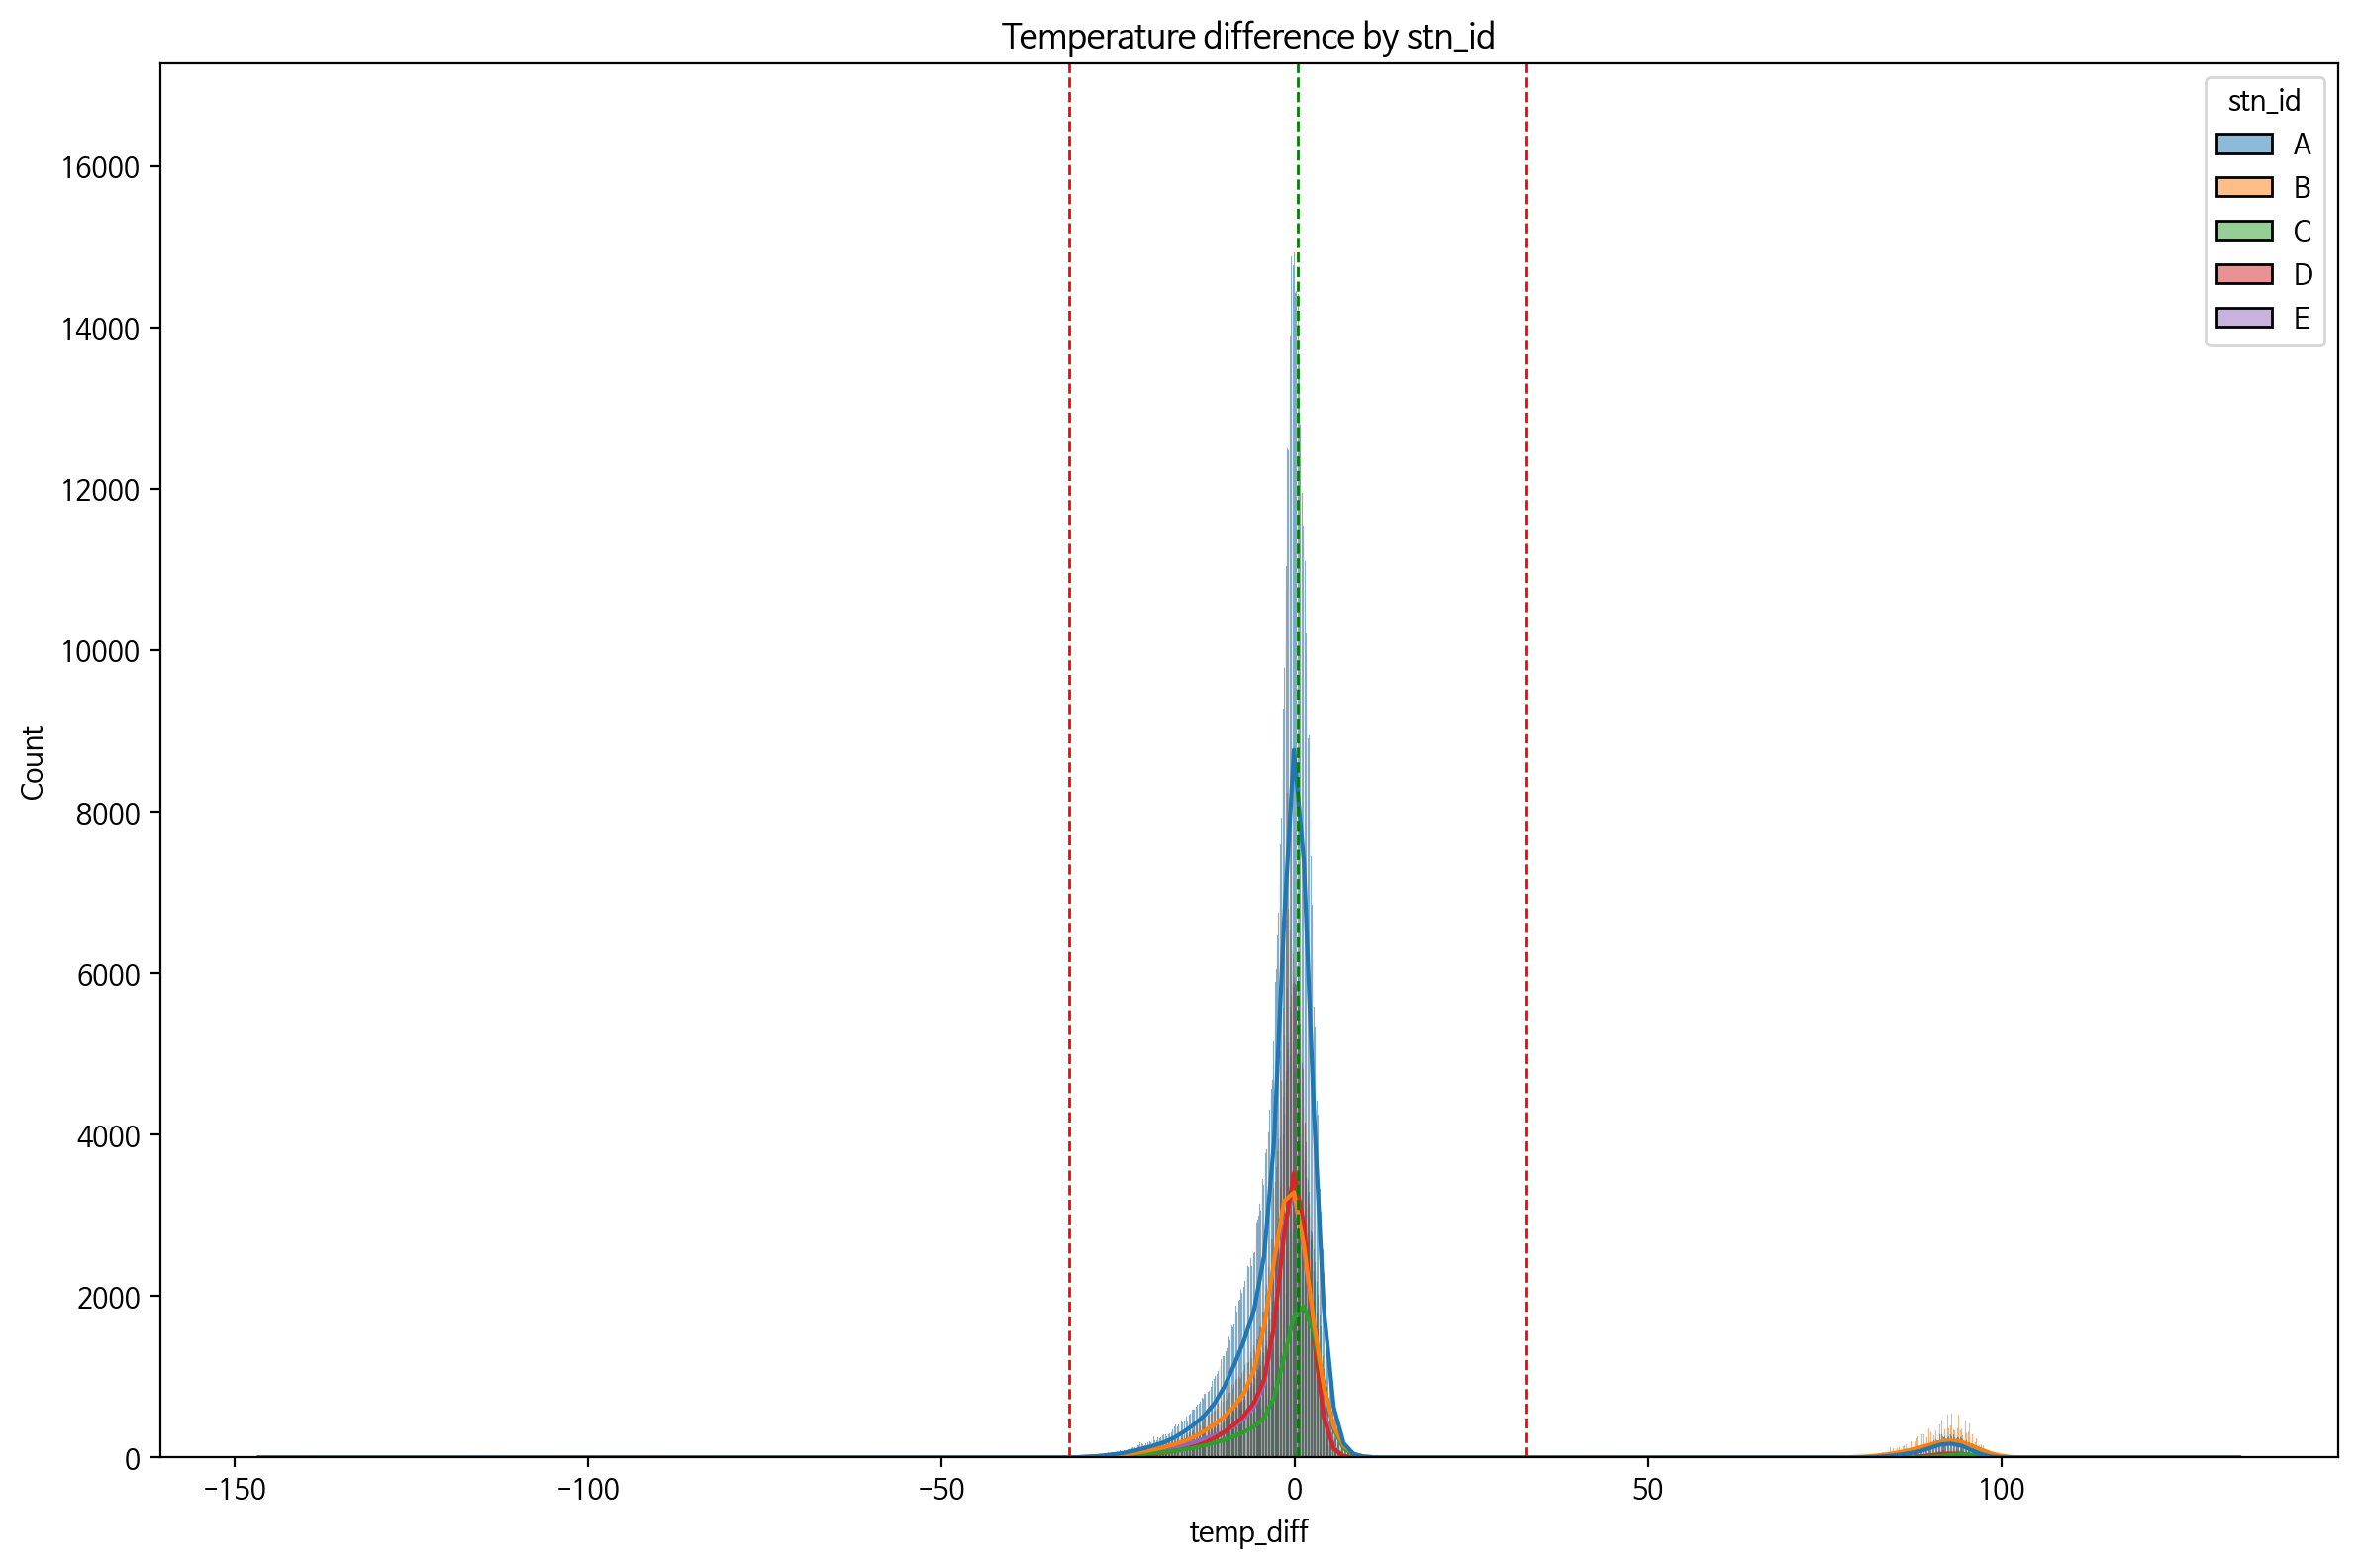

In [57]:
# 표준편차 기준 -2~2 범위 계산
std_minus_2 = np.mean(train_df["temp_diff"]) - 2 * np.std(train_df["temp_diff"])
std_plus_2 = np.mean(train_df["temp_diff"]) + 2 * np.std(train_df["temp_diff"])

plt.figure(figsize=(12, 8))

# 히스토그램 생성
sns.histplot(data=train_df, 
             x="temp_diff", 
             kde=True, 
             hue="stn_id",
             hue_order=["A", "B", "C", "D", "E"])

# 평균선 추가
plt.axvline(np.mean(train_df["temp_diff"]), color='g', linestyle='--', linewidth=1, label='Mean')

# 표준편차 기준 -2~2 범위선 추가
plt.axvline(std_minus_2, color='r', linestyle='--', linewidth=1, label='-2 Std Dev')
plt.axvline(std_plus_2, color='r', linestyle='--', linewidth=1, label='+2 Std Dev')


plt.title("Temperature difference by stn_id")
plt.tight_layout()

plt.show()

In [53]:
# 월별 temp_diff 컬럼 평균
train_df.groupby("month")["temp_diff"].mean()

month
1     12.221264
2      6.324143
3     -0.973415
4     -2.889874
5     -3.761579
6     -3.895400
7     -3.080191
8     -2.450217
9     -2.213519
10    -2.108188
11    -0.177308
12     8.696095
Name: temp_diff, dtype: float64

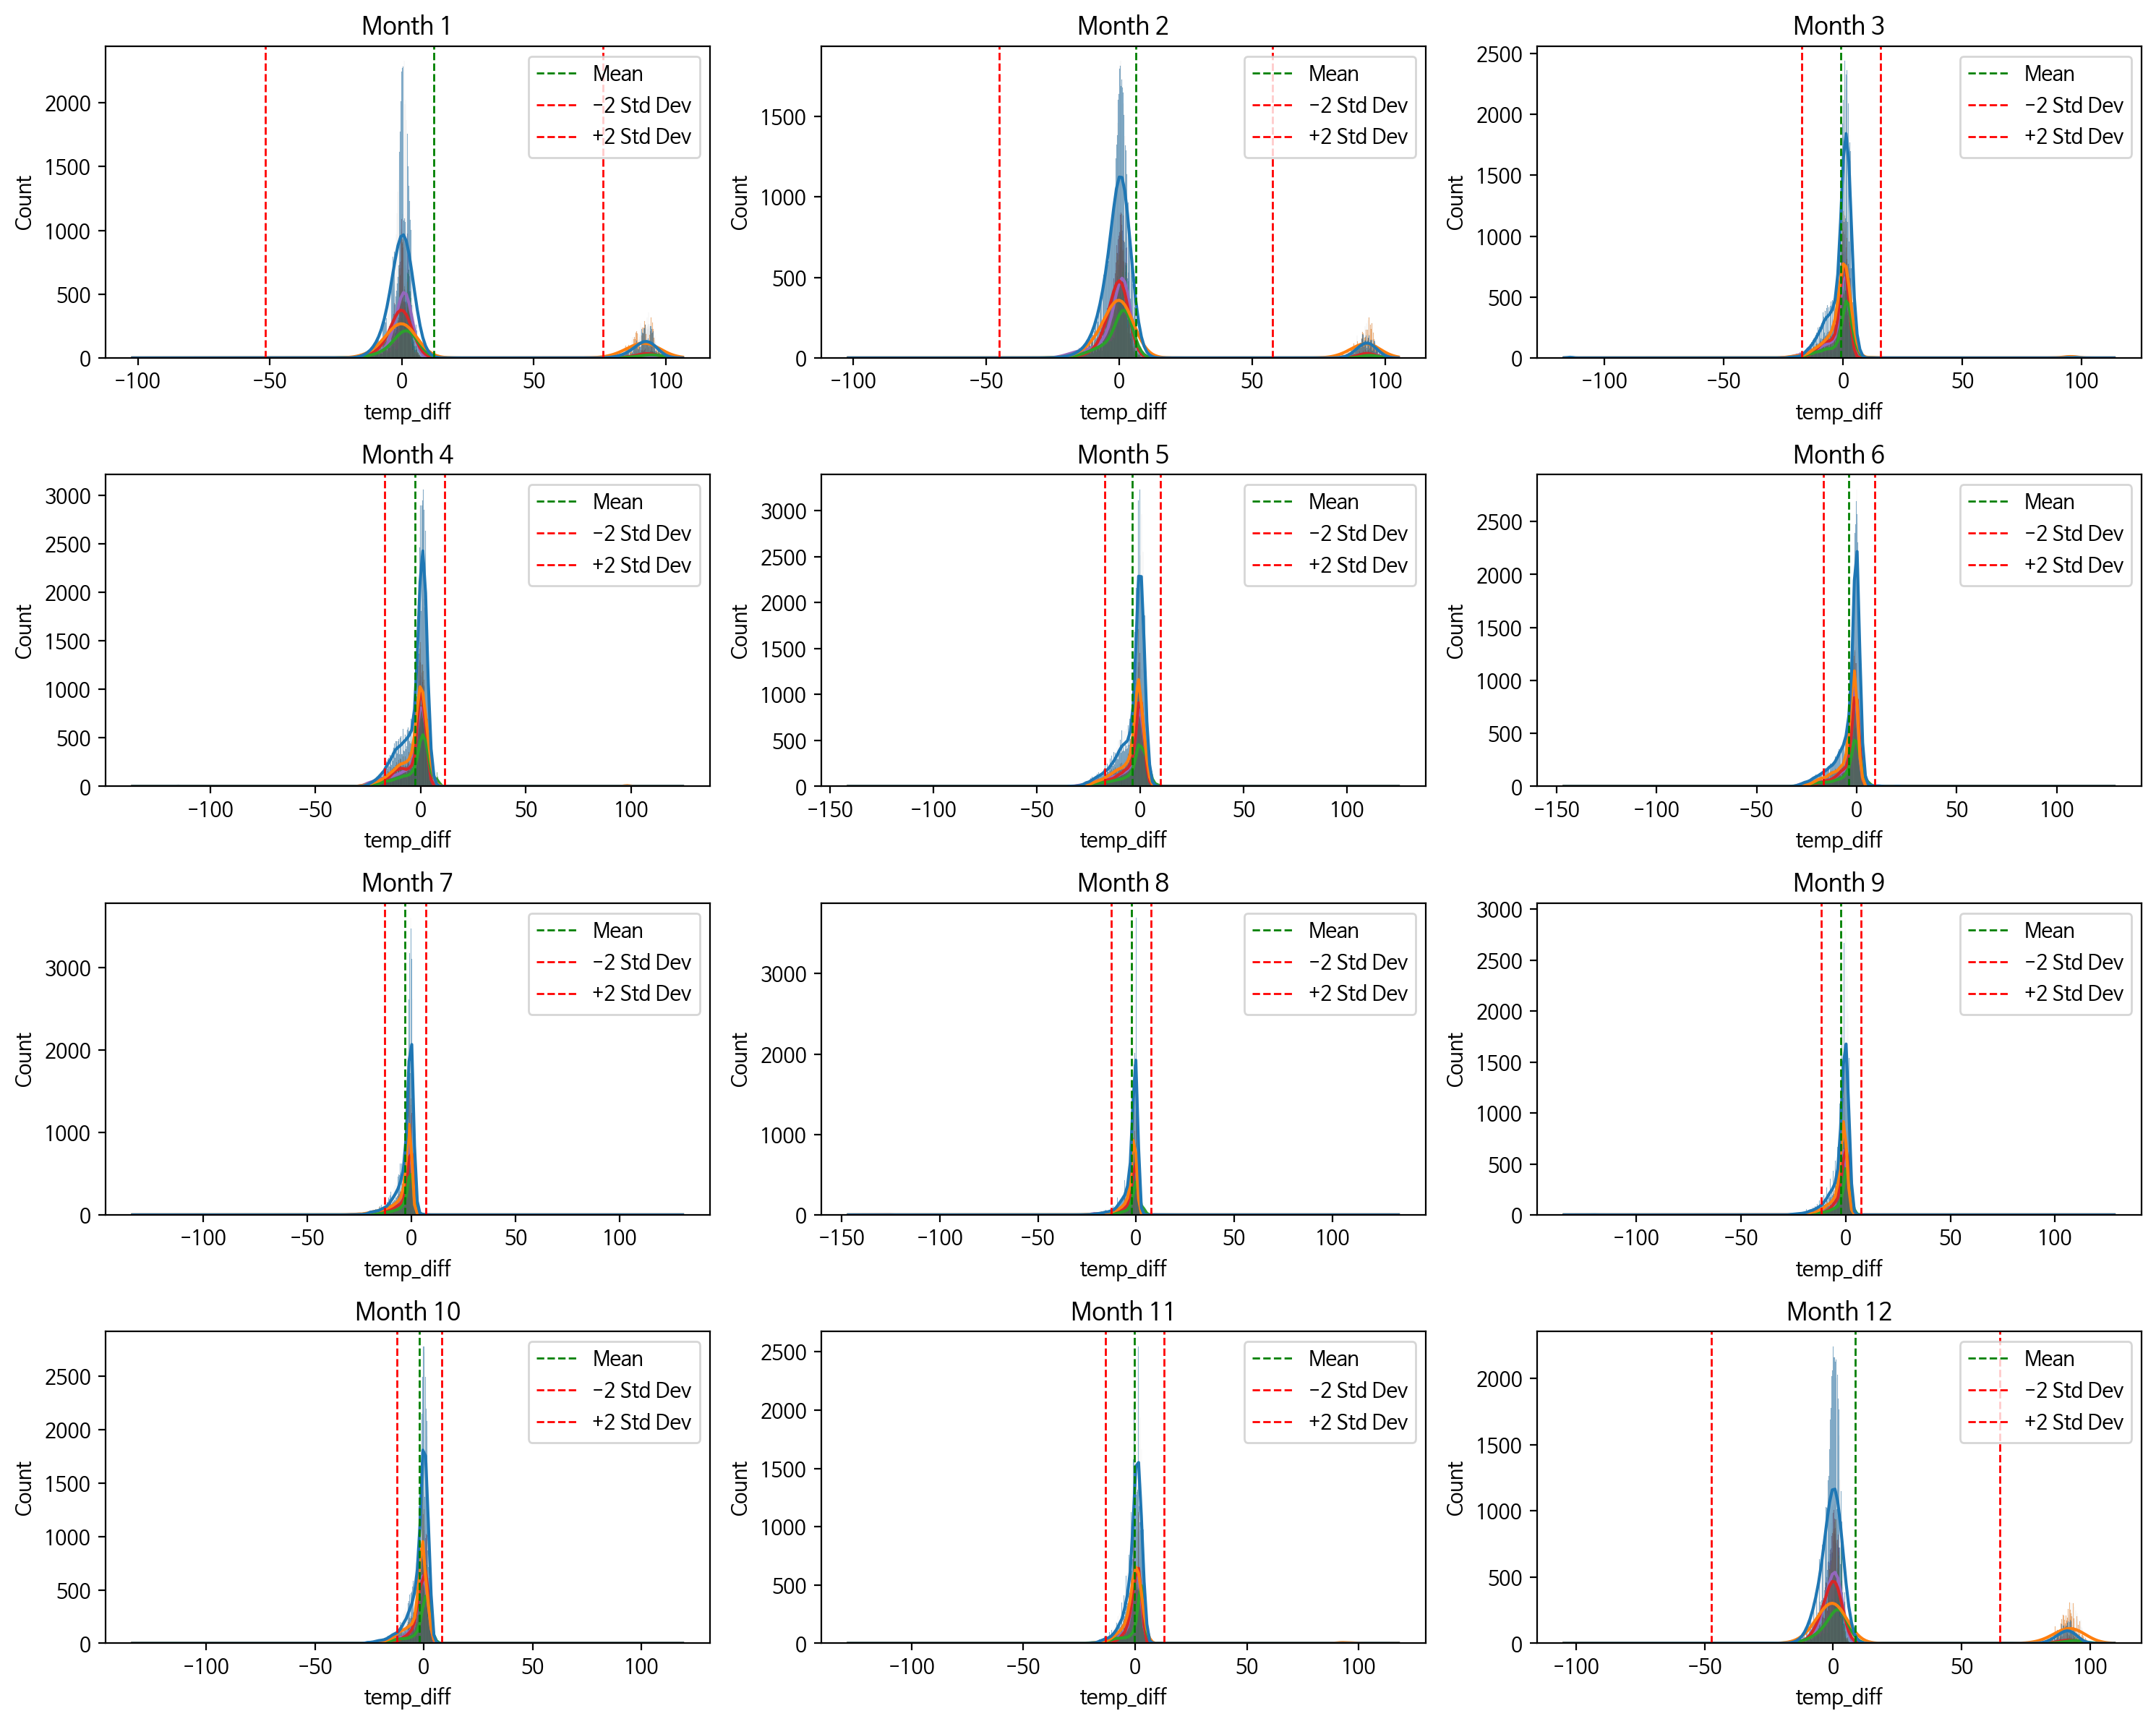

In [61]:
# 서브플롯 생성
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

# 12개월에 대해 반복
for month in range(1, 13):
    ax = axes[month - 1]

    month_cond = train_df["month"] == month
    month_mean = np.mean(train_df[month_cond]["temp_diff"])
    std_minus_2 = month_mean - 2 * np.std(train_df[month_cond]["temp_diff"])
    std_plus_2 = month_mean + 2 * np.std(train_df[month_cond]["temp_diff"])

    # 히스토그램 생성
    sns.histplot(data=train_df[month_cond], 
                 x="temp_diff", 
                 kde=True, 
                 hue="stn_id",
                 hue_order=["A", "B", "C", "D", "E"],
                 ax=ax)

    # 평균선 추가
    ax.axvline(month_mean, color='g', linestyle='--', linewidth=1, label='Mean')

    # 표준편차 기준 -2~2 범위선 추가
    ax.axvline(std_minus_2, color='r', linestyle='--', linewidth=1, label='-2 Std Dev')
    ax.axvline(std_plus_2, color='r', linestyle='--', linewidth=1, label='+2 Std Dev')

    ax.set_title(f"Month {month}")
    ax.legend()

plt.tight_layout()
plt.show()

# 겨울 (12, 1, 2)에 temp_diff 큰 숫자들 발견됨
# 결측치가 -99.9로 처리되어서 그런듯
# 결측치가 주로 겨울에 몰려있다.

#### 4-3-2. 이상치 처리
- `temp_diff` 표준편차 기준 -2 ~ 2 범위로 이상치 판단
- `ta`, `ts`, `hm`, `ws10_ms` : 표준편차 기준 -3 ~ 3 범위로 이상치 판단

In [107]:
with open(train_pkl_path,'rb') as f:
    train_df = pickle.load(f)

with open(val_pkl_path,'rb') as f:
    val_df = pickle.load(f)

with open(test_pkl_path,'rb') as f:
    test_df = pickle.load(f)

In [109]:
# 상대습도 0인 데이터 치환
train_df['hm'] = train_df['hm'].replace(0, np.nan)

In [108]:
def replace_outliers_with_nan(dataframe, columns, threshold=2):
    dataframe_copy = dataframe.copy()
    
    for column in columns:
        for month in range(1, 13):
            month_cond = dataframe_copy["month"] == month
            data = dataframe_copy.loc[month_cond, column]
            
            if data.empty:
                continue
            
            z_scores = np.abs((data - np.mean(data)) / np.std(data))
            
            # 이상치를 np.nan으로 대체
            dataframe_copy.loc[month_cond & (z_scores > threshold), column] = np.nan
    
    return dataframe_copy

In [118]:
# 월별 이상치 (표준편차 -2 ~ +2 기준) 확인 후 NaN으로 변경
train_no_outlier_df = replace_outliers_with_nan(train_df, ["temp_diff"])

In [119]:
# 월별 이상치 (표준편차 -3 ~ +3 기준) 확인 후 NaN으로 변경
train_no_outlier_df = replace_outliers_with_nan(train_df, ["ta", "ts", "hm", "ws10_ms"], 3)

#### 4-3-3. 이상치, 결측치 제거

In [121]:
def drop_nan(df):
    df['hm'] = df['hm'].replace(0, np.nan)
    df = df.replace({-99:np.nan, -99.9:np.nan})    
    # train_df = train_df.replace({-99:np.nan, -99.9:np.nan})
    # test_df = test_df.replace({-99:np.nan, -99.9:np.nan})
    df.dropna(inplace=True)
    
    return df

In [123]:
train_no_outlier_df = drop_nan(train_no_outlier_df)

In [124]:
print("이상치 처리 전 Train 데이터셋 shape:", train_df.shape)

이상치 처리 전 Train 데이터셋 shape: (2367343, 18)


In [125]:
print("Train 데이터 Outlier 제거 :",  train_df.shape[0] - train_no_outlier_df.shape[0], "개")

Train 데이터 Outlier 제거 : 128383 개


In [126]:
print("이상치 처리 후 Train 데이터셋 shape:", train_no_outlier_df.shape)

이상치 처리 후 Train 데이터셋 shape: (2238960, 18)


### 4-4. 컬럼별 시각화

#### 4-4-1. 수치형 변수

In [127]:
# 수치형 변수 중, vis1 컬럼은 제거 예정
num_cols = train_no_outlier_df.drop(columns="vis1").select_dtypes(include=np.number).columns

print(num_cols)
print(len(num_cols),"개")

Index(['time', 'ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts', 'dew_point',
       'temp_diff'],
      dtype='object')
9 개


In [128]:
def kde_factor_class(dataset, columns_list, class_column = 'class'):

    colors = {
        1: '#FF0000',
        2: '#00FF00',
        3: '#0000FF',
        4: '#777777'
    }

    # about_columns = dataset.columns[0:-2]
    num_columns = len(columns_list)

    # Determine the number of rows and columns for the subplots
    num_rows = (num_columns + 1) // 2

    fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))

    for idx, column in enumerate(columns_list):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]

        for i in range(1, 5):
            temp_df = dataset[dataset[class_column] == i]
            sns.kdeplot(temp_df[column], label=i, fill=True, color=colors[i], ax=ax)

        ax.set_title("class별 " + column + "KDE plot")
        ax.set_xlabel(column)
        ax.set_ylabel("density")
        ax.legend()

    # Remove any empty subplots
    for j in range(idx + 1, num_rows * 2):
        fig.delaxes(axes.flatten()[j])

    fig.suptitle("KDE Distribution of Numerical Columns by class", fontsize=16)

    # Adjust layout to make room for the figure title
    plt.subplots_adjust(top=0.92, hspace=0.4)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()

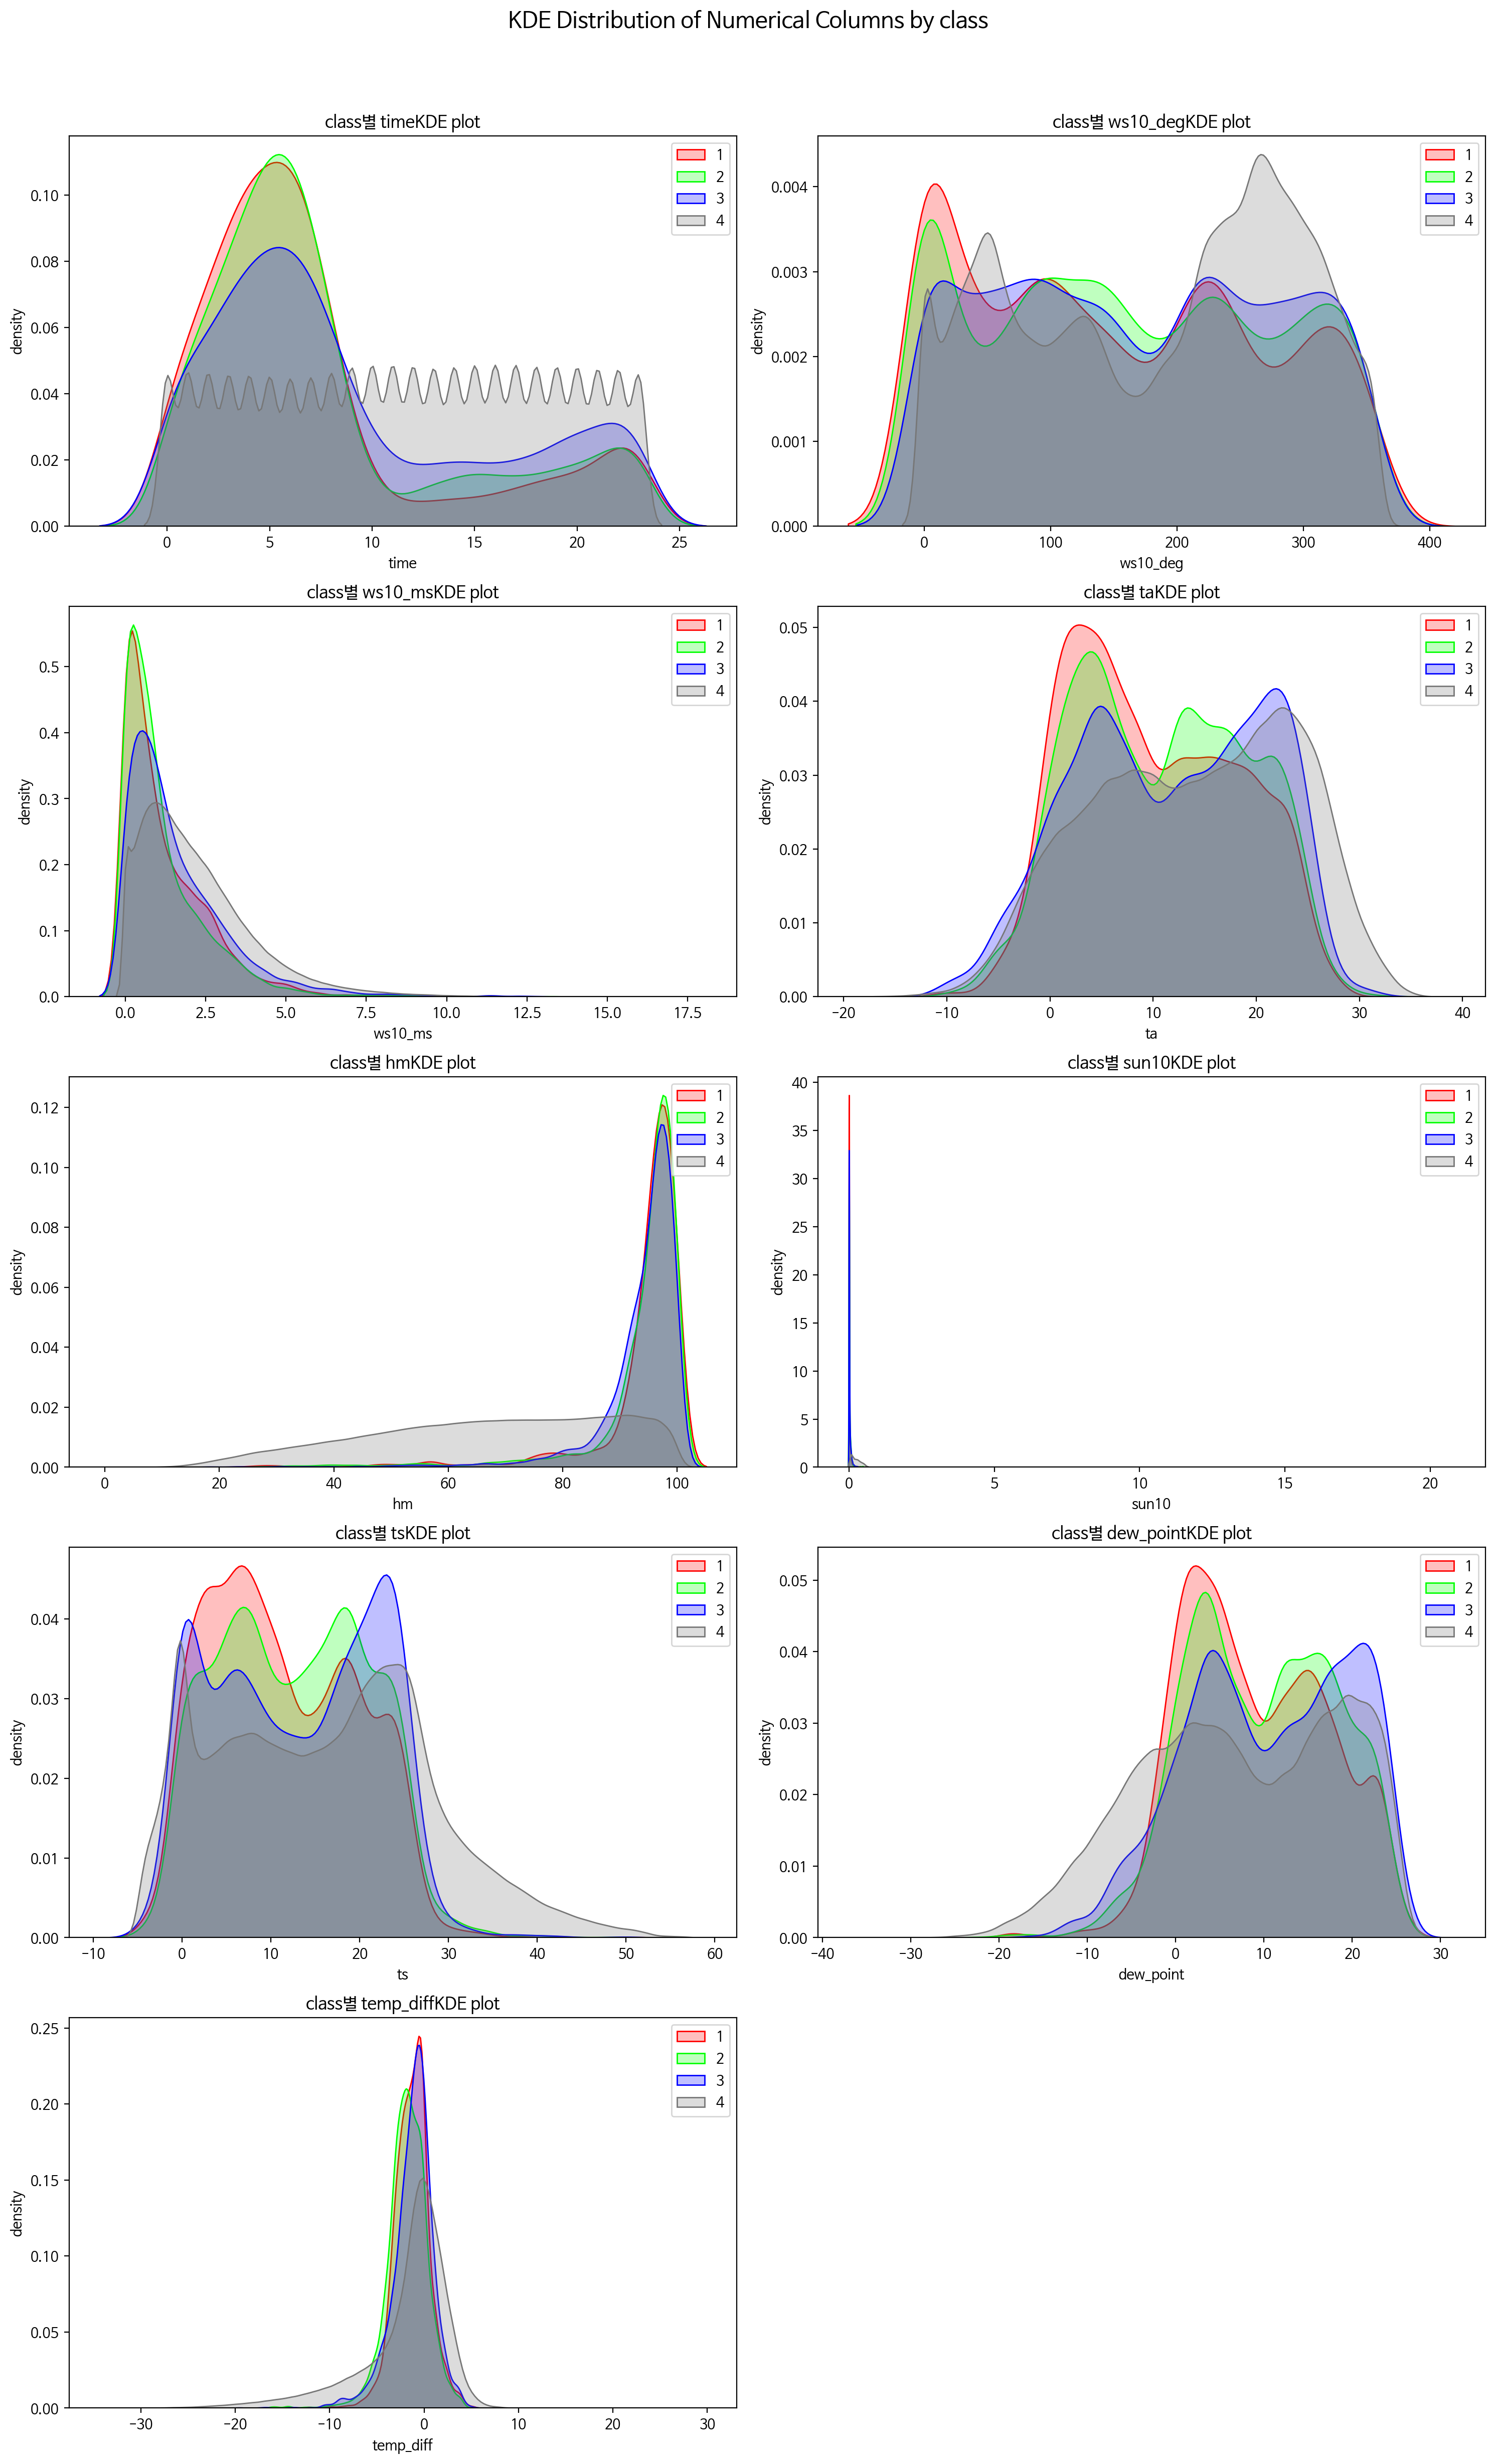

In [129]:
kde_factor_class(train_no_outlier_df, num_cols)

#### 4-4-2. 명목형 변수

In [130]:
str_cols = train_no_outlier_df.select_dtypes(exclude=np.number).columns
str_cols

Index(['year', 'month', 'stn_id', 're', 'class', 'is_fog', 'dew_reached',
       'ws10_dir'],
      dtype='object')

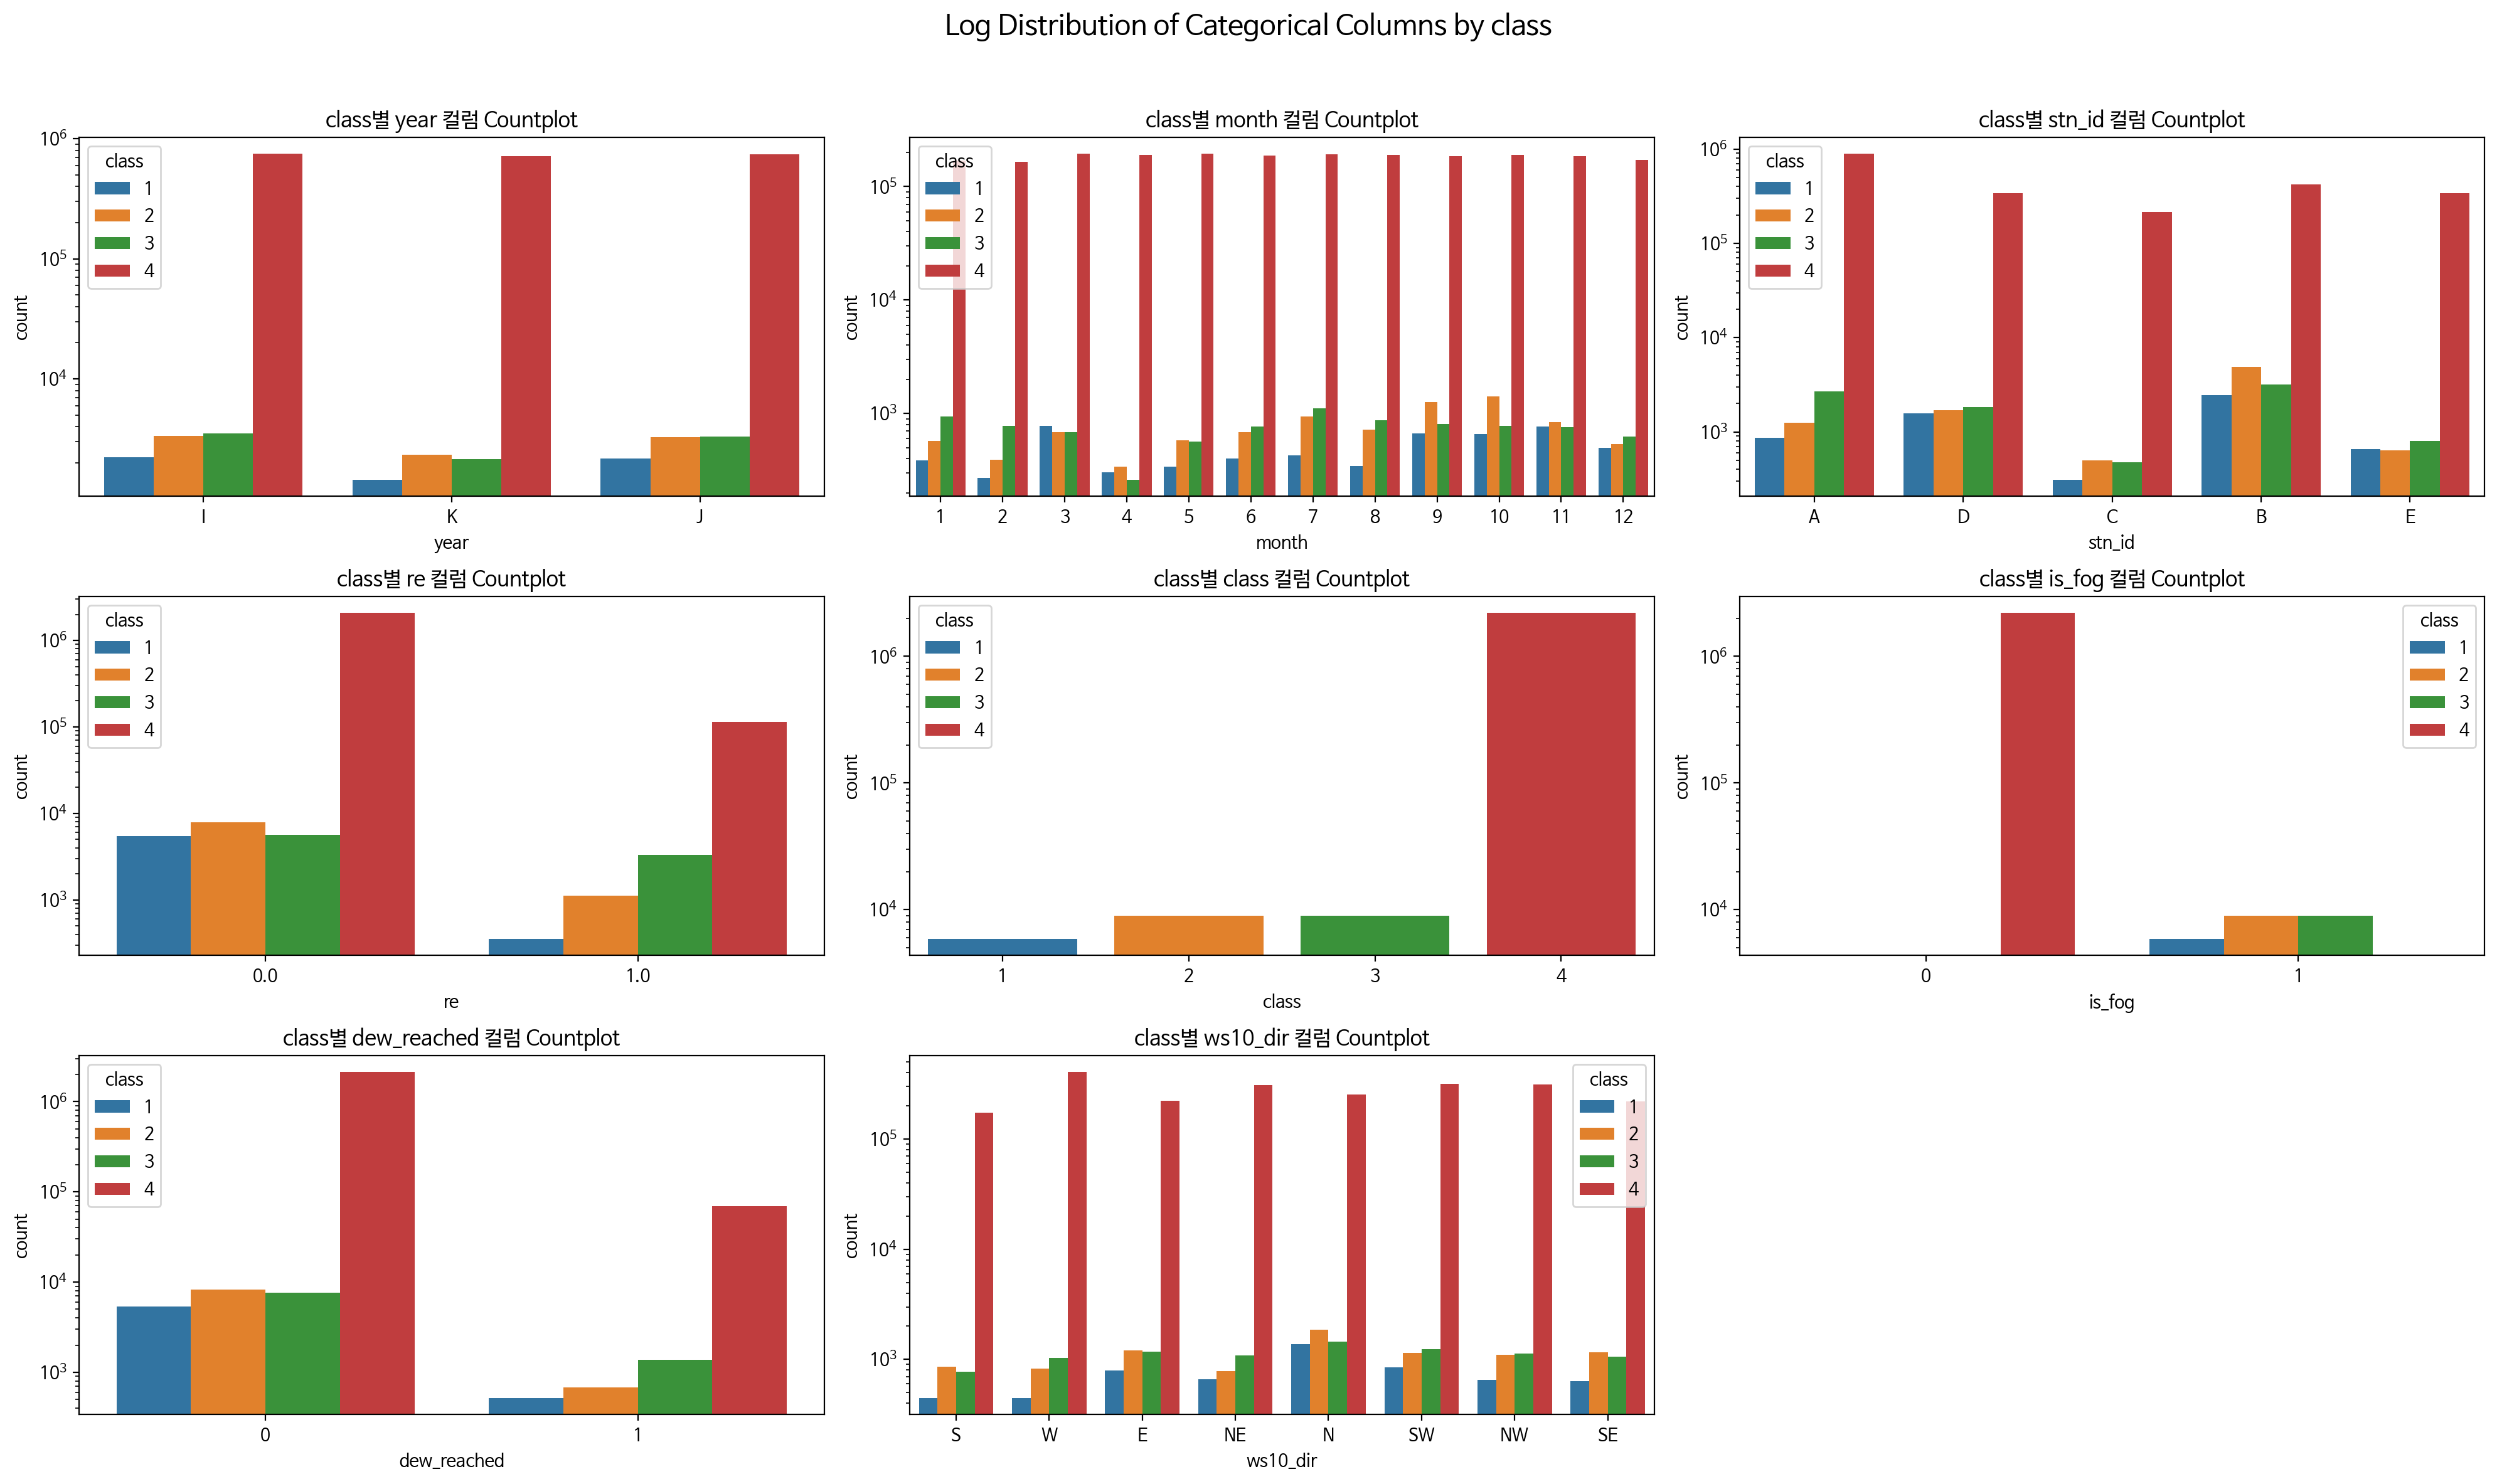

In [131]:
# subplot 생성
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 12))

# flatten()을 통해 axes를 1차원 array로 변환
axes = axes.flatten()

for col, ax in zip(str_cols, axes):
    sns.countplot(data=train_no_outlier_df, x=col, ax=ax, hue="class")
    # if col == "class":
    #     sns.countplot(data=train_no_outlier_df, x=col, ax=ax, hue="class")
    # else:
    #     sns.countplot(data=train_no_outlier_df, x=col, ax=ax, hue="class")
    
    # y축을 로그 스케일로 설정
    ax.set_yscale('log')
    # ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("class별 " + col + " 컬럼 Countplot")

# 빈 subplot 제거
if len(str_cols) < len(axes):
    for i in range(len(str_cols), len(axes)):
        fig.delaxes(axes[i])

fig.suptitle("Log Distribution of Categorical Columns by class", fontsize=16)

# Adjust layout to make room for the figure title
plt.subplots_adjust(top=0.92, hspace=0.4)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()


### 4-5. 상관관계 확인

In [132]:
num_cols = train_no_outlier_df.describe().columns
train_df_corr = train_no_outlier_df[num_cols].corr()

train_df_corr.style.background_gradient()

,time,ws10_deg,ws10_ms,ta,hm,sun10,ts,vis1,dew_point,temp_diff
time,1.000000,0.083973,0.122172,0.113939,-0.240981,0.056691,0.110302,0.103971,-0.012087,-0.042893
ws10_deg,0.083973,1.000000,0.200720,-0.068562,-0.226160,0.088535,-0.044615,0.030806,-0.159925,-0.027113
ws10_ms,0.122172,0.200720,1.000000,0.009749,-0.293124,0.219891,0.071836,0.144540,-0.120733,-0.155442
ta,0.113939,-0.068562,0.009749,1.000000,0.147742,0.263972,0.917515,0.073324,0.887843,-0.253470
hm,-0.240981,-0.226160,-0.293124,0.147742,1.000000,-0.428777,0.016168,-0.344128,0.576866,0.252944
sun10,0.056691,0.088535,0.219891,0.263972,-0.428777,1.000000,0.540918,0.163961,0.016445,-0.793496
ts,0.110302,-0.044615,0.071836,0.917515,0.016168,0.540918,1.000000,0.112986,0.755769,-0.617276
vis1,0.103971,0.030806,0.144540,0.073324,-0.344128,0.163961,0.112986,1.000000,-0.086363,-0.129766
dew_point,-0.012087,-0.159925,-0.120733,0.887843,0.576866,0.016445,0.755769,-0.086363,1.000000,-0.081922
temp_diff,-0.042893,-0.027113,-0.155442,-0.253470,0.252944,-0.793496,-0.617276,-0.129766,-0.081922,1.000000


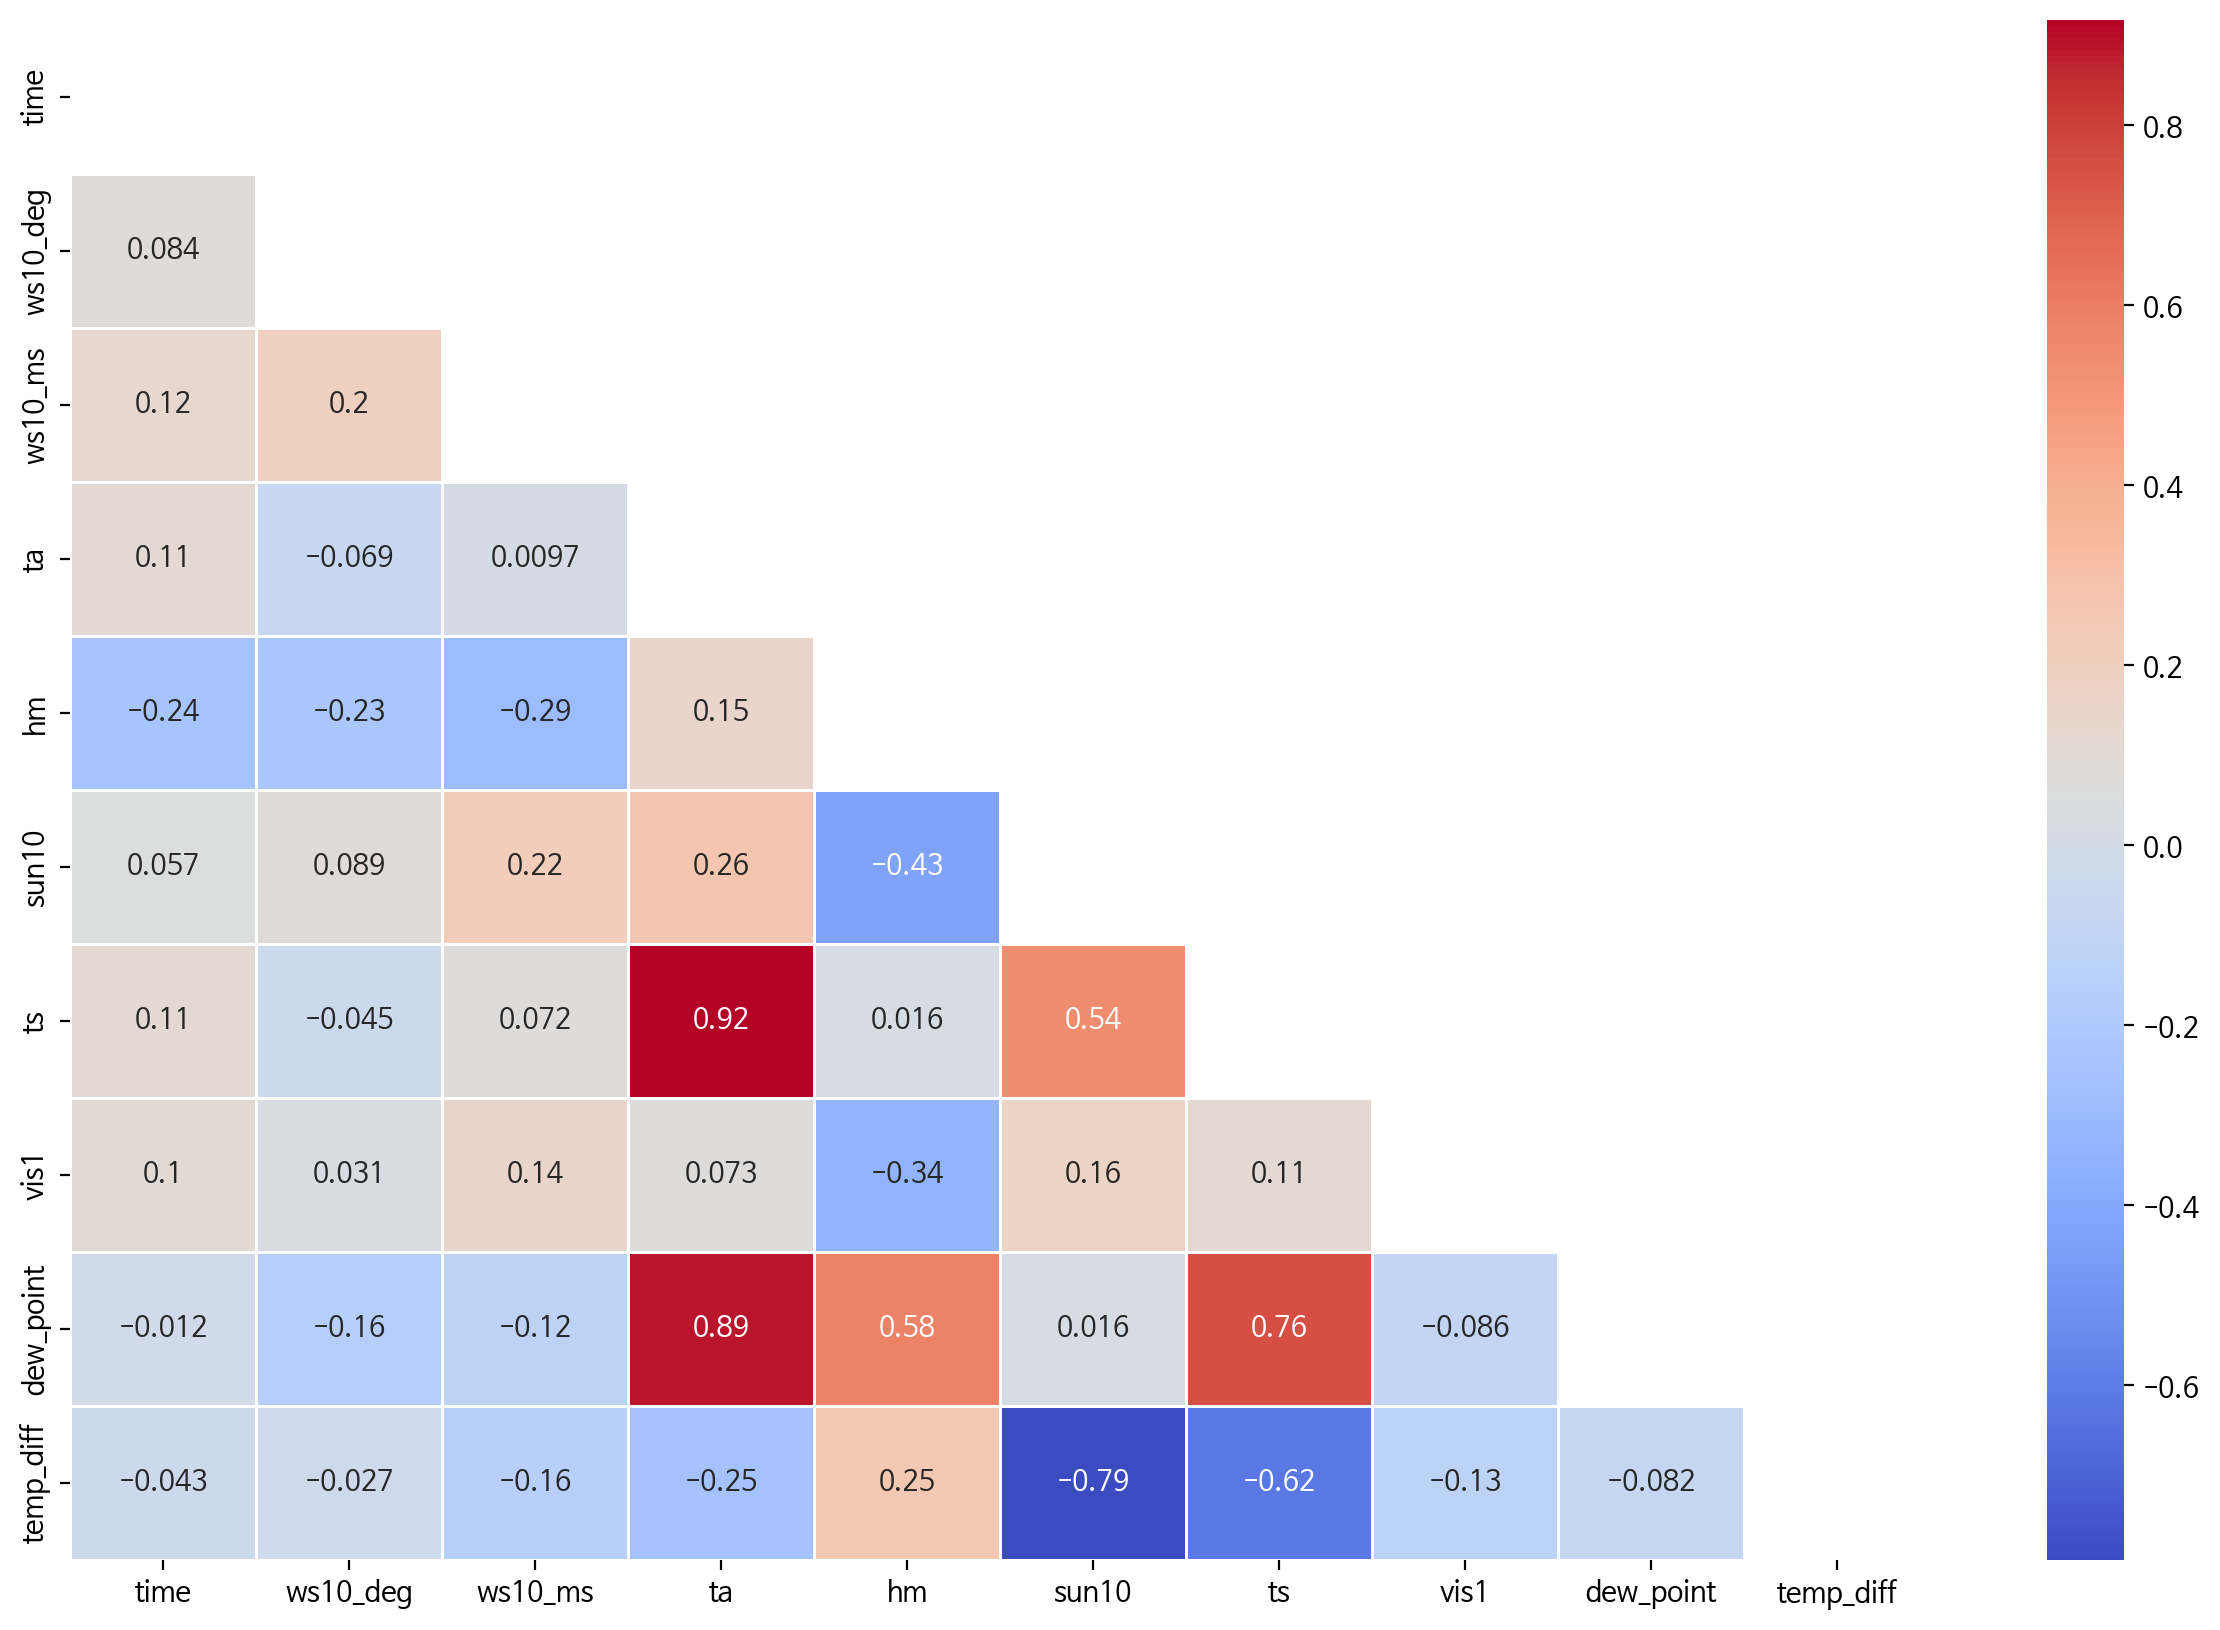

In [133]:
plt.figure(figsize=(15,10))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(train_df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train_df_corr,
            annot=True,         # 실제 값을 표시한다
            mask=mask,          # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,      # 경계면 실선으로 구분하기
            cmap='coolwarm')
plt.show()

#### 4-5-1. 상관관계 결과
- 강한 양적 선형관계 (0.7 ~ 1.0)
    - `ta` - `ts` : 평균 기온 - 평균 지면온도 (0.95)
    - `ta` - `dew_point` : 평균 기온 - 이슬점 온도 (0.9)
    - `ts` - `dew_point` : 평균 지면 온도 - 이슬점 (0.83) <br>
    <br>
- 뚜렷한 양적 선형관계 (0.3 ~ 0.7)
    - `hm` - `dew_point` : 습도 - 이슬점 (0.59)
    - `sun10` - `ts` : 일사량 - 평균 지면 온도 (0.42)
    - `diff_z_scores` - `sun10` : temp_diff 컬럼의 z-score - 일사량 <br>
    <br>
- 뚜렷한 음적 선형관계 (-0.7 ~ -0.3)
    - `vis1` - `hm` : 평균 시정 - 상대 습도 (-0.34)
    - `hm` - `sum10` : 상대 습도 - 일사량 (-0.38)
    - `hm` - `diff_z_scores` : 상대 습도 - temp_diff 컬럼의 z-score (-0.4)
    - `temp_diff` - `ts` : 기온-지면 온도 차이 - 기온 (-0.49) <br>
    <br>
- 강한 음적 선형관계 (-1.0 ~ -0.7)
    - `sun10` - `temp_diff` : 일사량 - 기온-지면 온도 차이 (-0.73)


### 4-6 일사량 처리
- `sun10`의 최대값은 24.xx, but 안개가 낀 경우(`is_fog` = 1)의 **최대값은 0.69**로 매우 낮음
- `sun10` ≥ 1인 경우 볼 것도 없이 `class` = 4이므로 아예 **높은 가중치**를 주는 것이 유리하다고 판단 → `sun10` = 100으로 변경

In [136]:
sun10_cond = (train_no_outlier_df["sun10"] >= 1)
train_no_outlier_df.loc[sun10_cond, "sun10"] = 100

## 5. 데이터셋 저장

In [138]:
# 전처리 마친 데이터셋 저장할 경로 설정하는 함수

def save_local_path(train_df, val_df, test_df):
        
    # 작업 디렉토리 origin_dir에 선언
    origin_dir = os.getcwd()

    # ".." : 상위 디렉토리로 이동
    os.chdir("..")

    # 전처리 거친 데이터셋 저장할 이름 지정
    save_name_train = "fog_train_mod.csv"
    save_name_val = "fog_val_mod.csv"
    save_name_test = "fog_test_mod.csv"

    # 전처리 거친 데이터셋 저장 경로 설정
    train_save_path = os.path.join(os.getcwd(), "fog_data", save_name_train)
    val_save_path = os.path.join(os.getcwd(), "fog_data", save_name_val)
    test_save_path = os.path.join(os.getcwd(), "fog_data", save_name_test)
    
    # 운영체제가 윈도우일 경우, "\\"를 "/"로 바꿔줘야 한다
    if os.name == "nt":
        train_save_path = train_save_path.replace("\\", "/")
        val_save_path = val_save_path.replace("\\", "/")
        test_save_path = test_save_path.replace("\\", "/")

    # # origin_dir로 경로 다시 변경 (초기화)
    os.chdir(origin_dir)

    return train_save_path, val_save_path, test_save_path

In [139]:
# def save_colab_path(train_df, test_df):
#     origin_dir = os.getcwd()

#     # 전처리 거친 데이터셋 저장할 이름 지정
#     save_name_train = "fog_train_modified.csv"
#     save_name_test = "fog_test_modified.csv"

#     # 전처리 거친 데이터셋 저장 경로 설정
#     train_save_path = os.path.join(train_path[:48], save_name_train)
#     test_save_path = os.path.join(test_path[:48], save_name_test)
    
#     return train_save_path, test_save_path

In [140]:
# 데이터셋 저장 경로 함수 적용 후 확인
train_save_path, val_save_path, test_save_path = save_local_path(train_no_outlier_df, val_df, test_df)

print(train_save_path)
print(val_save_path)
print(test_save_path)


c:/Users/aryij/Documents/DataStudy/fog_data/fog_train_mod.csv
c:/Users/aryij/Documents/DataStudy/fog_data/fog_val_mod.csv
c:/Users/aryij/Documents/DataStudy/fog_data/fog_test_mod.csv


In [141]:
# 전처리 마친 데이터셋 저장
train_df.to_csv(train_save_path, index=False, encoding="utf-8")
val_df.to_csv(val_save_path, index=False, encoding="utf-8")
test_df.to_csv(test_save_path, index=False, encoding="utf-8")